In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils01 import GROParser

In [2]:
cb_mode = False
# cb_mode = True

In [3]:
gro = "input/solv_ions_prot.gro"
# gro = "input/topo.gro"
CUTOFF_RADIUS = 1.0

groparser = GROParser(gro, CUTOFF_RADIUS, cb_mode)
MAINCHAIN = groparser.mainchains
N_ATOMS = groparser.n_atoms
EACH_N_ATOMS = groparser.each_n_atoms
SLICE_INDECES = groparser.slice_indeces
ARRANGED_INDECES = groparser.arranged_indeces
REARRANGED_INDECES = groparser.rearranged_indeces
ADJACENT_INDECES = groparser.adjacent_indeces
AB_INDECES = groparser.ab_indeces
ATOM_ALIGN = groparser.atom_align
TARGET_ATOM_INDECES_FOR_XVG = groparser.target_atom_indeces_for_xvg

In [4]:
INIT_ANGLES = groparser.init_angles

In [5]:
np.mean(INIT_ANGLES[SLICE_INDECES['CA'][0]:SLICE_INDECES['CA'][1]])

111.23412857521987

In [6]:
N_BINS = 20

# read trj

In [7]:
filepath = "input/xvg/2fs/mini/Protein-coord.xvg"

acttrj = pd.read_csv(filepath, comment='@', delimiter='\t',
                            header=None, skiprows=14).values[:, 1:]
acttrj = acttrj.reshape(acttrj.shape[0], -1, 3)[:, TARGET_ATOM_INDECES_FOR_XVG, :]
acttrj = acttrj[:, ARRANGED_INDECES, :]
acttrj.shape

(5001, 1236, 3)

In [8]:
# acttrj = acttrj[100:200]
acttrj = acttrj[200:300]
# acttrj = acttrj[:300]
# acttrj = acttrj[300:400]
# acttrj = acttrj[:499]

In [9]:
filepath = "remote-workspace/04-simulate/test60.npy"

# filepath = "workspace/04-simulate/length.npy"
# filepath = "workspace/04-simulate/length-angle.npy"
# filepath = "workspace/04-simulate/angle.npy"

prdtrj = np.load(filepath)
prdtrj = prdtrj[:, ARRANGED_INDECES, :]
prdtrj.shape

(499, 1236, 3)

In [10]:
prdtrj = prdtrj[200:300]
# prdtrj = prdtrj[:300]
# prdtrj = prdtrj[100:200]
# prdtrj = prdtrj[300:400]
# prdtrj = prdtrj[:100]

In [11]:
# prdtrj = acttrj

In [12]:
label1 = "GROMACS"
label2 = "MDMD"

In [13]:
snapshots = [0, 99]

# nm -> A

In [14]:
acttrj = acttrj * 10
prdtrj = prdtrj * 10

# RDF

In [15]:
def cal_rdf(trj, species, residues, cutoff=CUTOFF_RADIUS, n_bins=100):
    all_distances = []
    for residue in residues:
        i, j = SLICE_INDECES[species[0]]
        center_coords = trj[:, i:j, :]
        center_coords = center_coords[:, residue, :]

        i, j = SLICE_INDECES[species[1]]
        nearby_coords = trj[:, i:j, :]
        
        center_coords = np.tile(center_coords, nearby_coords.shape[1]).reshape(center_coords.shape[0], -1, 3)

        distances = np.sqrt(np.sum(np.square(np.subtract(nearby_coords, center_coords)), axis=2)).flatten()
        distances = distances[distances<=cutoff]
        all_distances.extend(distances.tolist())
    
    hist, bins = np.histogram(all_distances, bins=n_bins)
    dr = bins[1] - bins[0]
    rho = 1
    rdf = hist/(4*np.pi*np.power(bins[:-1],2)*dr*rho)
    return bins[:-1], rdf

In [16]:
species_list = [
    ['CA', 'N'],
    ['CA', 'C'],
    ['N', 'C'],
    ['C', 'O'],
    ['CA', 'O'],
    ['N', 'O'],
]

In [17]:
def plot_rdf(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        radiuses, rdf = cal_rdf(trj, species, residues)

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(radiuses, rdf)
        plt.scatter(radiuses, rdf)
        
        plt.xlabel("radius ($\AA$)")
        plt.ylabel("RDF like")

        plt.xlabel("radius ($\AA$)", fontsize=14)
        plt.ylabel("kind of RDF", fontsize=14)

        plt.title(f"{species[0]}-{species[1]} (peak: {radiuses[np.argmax(rdf)]:.2f})", fontsize=14)
        plt.xlim(0, CUTOFF_RADIUS)
        plt.tight_layout()

In [18]:
def plot_rdf_double(trj1, trj2, label1, label2):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        radiuses1, rdf1 = cal_rdf(trj1, species, residues)
        radiuses2, rdf2 = cal_rdf(trj2, species, residues)

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(radiuses1, rdf1, label=label1)
        plt.plot(radiuses2, rdf2, label=label2)

        plt.title(f"{species[0]}-{species[1]}", fontsize=14)
        
        plt.xlabel("radius ($\AA$)", fontsize=14)
        plt.ylabel("kind of RDF", fontsize=14)
        
        plt.legend()
        plt.tight_layout()

In [19]:
def plot_each_peak(trj):
    fig = plt.figure(figsize=(10,4*len(species_list)))

    for i, species in enumerate(species_list):
        residues = range(EACH_N_ATOMS[species[0]])
        
        radiuses_rdfs = [cal_rdf(trj[[t], :, :], species, residues) for t in range(trj.shape[0])]
        peaks = [radiuses[np.argmax(rdf)] for radiuses, rdf in radiuses_rdfs]

        fig.add_subplot(len(species_list), 1, i+1)

        plt.plot(list(range(trj.shape[0])), peaks)
        plt.scatter(list(range(trj.shape[0])), peaks)

        plt.title(f"{species[0]}-{species[1]}", fontsize=14)
        plt.tight_layout()

## actual

### whole time

In [20]:
# plot_rdf(acttrj)

### peak each time

In [21]:
# plot_each_peak(acttrj)

## pred

### whole time

In [22]:
# plot_rdf(prdtrj)

In [23]:
# plot_each_peak(prdtrj)

## act-pred-wholetime

In [24]:
# plot_rdf_double(acttrj, prdtrj, "Gromacs", "Simplified")

# 隣の原子との距離

In [25]:
approved_species = {
    'CA-N': [0, 0],
    'CA-C': [1, 0],
    'N-C': [0, 1],
    'N-CA': [1, 0],
    'C-CA': [0, 0],
    'C-O': [1, 0],
    'C-N': [1, 1],
    'O-C': [0, 0]
}

In [26]:
# def cal_radius_list(trj, center_species, species2):
#     l, u = SLICE_INDECES[center_species]
#     radiuses = []
#     for i in range(l, u):
#         center_coords = trj[:, i, :]

#         try:
#             x,y = approved_species[f"{center_species}-{species2}"]
#             coords2 = trj[:, ADJACENT_INDECES[i][x][y], :]
#         except IndexError:
#             continue
        
#         radiuses.extend(np.sqrt(np.sum(np.square(np.subtract(coords2, center_coords)), axis=1)).flatten().tolist())
    
#     return radiuses

def cal_radius_arr(trj, center_species, species2):
    l, u = SLICE_INDECES[center_species]
    radiuses = []
    for i in range(l, u):
        center_coords = trj[:, i, :]

        try:
            x,y = approved_species[f"{center_species}-{species2}"]
            coords2 = trj[:, ADJACENT_INDECES[i][x][y], :]
        except IndexError:
            continue
        
        radiuses.append(np.sqrt(np.sum(np.square(np.subtract(coords2, center_coords)), axis=1)))
    
    return np.array(radiuses).transpose(1, 0)

In [27]:
species_list = [
    ['CA', 'N'], ['CA', 'C'], ['N', 'C'], ['C', 'O'], ['C', 'N']
]

N_FIGS =len(species_list)

In [28]:
def plot_radiuses_hist(trj):
    fig = plt.figure(figsize=(20,5*N_FIGS))

    i = 0
    for species_center, species2 in species_list:
        i += 1
        fig.add_subplot(N_FIGS, 1, i)

        radius_list = cal_radius_list(trj, species_center, species2)
        hist, bins = np.histogram(radius_list, bins=N_BINS)

        plt.bar([f"{round((bins[i]+bins[i+1])/2, 1)}" for i in range(len(hist))], hist)

        plt.xlabel("radius ($\AA$)", fontsize=14)
        plt.ylabel("Frequency", fontsize=14)

        plt.title(f"{species_center}-{species2} (mean: {np.mean(radius_list)})", fontsize=14)
    plt.tight_layout()

In [29]:
def double_plot_radiuses_hist(trj1, trj2, residue_list=None):
    fig = plt.figure(figsize=(15,5*N_FIGS*2))

    i = 0
    for species_center, species2 in species_list:
        radius_arr1 = cal_radius_arr(trj1, species_center, species2)
        radius_arr2 = cal_radius_arr(trj2, species_center, species2)
        
        if residue_list is not None:
            radius_arr1 = radius_arr1[:, residue_list]
            radius_arr2 = radius_arr2[:, residue_list]
        
        radius_list1 = radius_arr1.flatten().tolist()
        radius_list2 = radius_arr2.flatten().tolist()
        
#         binmax = max(radius_list1 + radius_list2)
#         binmin = min(radius_list1 + radius_list2)
        binmax = np.mean(radius_list1) + 0.15
        binmin = np.mean(radius_list1) - 0.15

        # bar1
        i += 1
        fig.add_subplot(N_FIGS*2, 1, i)
    
        plt.hist(radius_list1, range=(binmin, binmax), bins=N_BINS, rwidth=0.9, alpha=1, label=f"{label1}(400-600fs)")
        
        # bar2
        plt.hist(radius_list2, color="#ff7f00", range=(binmin, binmax), bins=N_BINS, rwidth=0.8, alpha=0.7, label=f"{label2}(400-600fs)")

        plt.xlabel("radius ($\AA$)", fontsize=30)
        plt.ylabel("Frequency", fontsize=30)
        plt.tick_params(labelsize=30)
        plt.legend(fontsize=25)

#         plt.title(f"{species_center}-{species2} (mean: {np.mean(radius_list2)}, std: {np.std(radius_list2)})", fontsize=14)
        print(f"{species_center}-{species2} (mean: {np.mean(radius_list1)}, std: {np.std(radius_list1)}) (mean: {np.mean(radius_list2)}, std: {np.std(radius_list2)})")

    plt.tight_layout()

## hist

In [30]:
residue_list=list(range(0, 70)) + list(range(90, 130)) + list(range(160, 200)) +  list(range(220, 308))
# residue_list=list(range(150, 200))

CA-N (mean: 1.4558378615366991, std: 0.030430285577622722) (mean: 1.4620806828146495, std: 0.038944934551323564)
CA-C (mean: 1.5243044816152784, std: 0.03407374818089325) (mean: 1.537468104872274, std: 0.046274003426198286)
N-C (mean: 1.3484452753715508, std: 0.028001563788261005) (mean: 1.354919942520586, std: 0.03804045012475868)
C-O (mean: 1.2303848169929588, std: 0.02224471274817394) (mean: 1.235319664544225, std: 0.02811652197523755)
C-N (mean: 1.3484452753715508, std: 0.028001563788261005) (mean: 1.354919942520586, std: 0.03804045012475868)


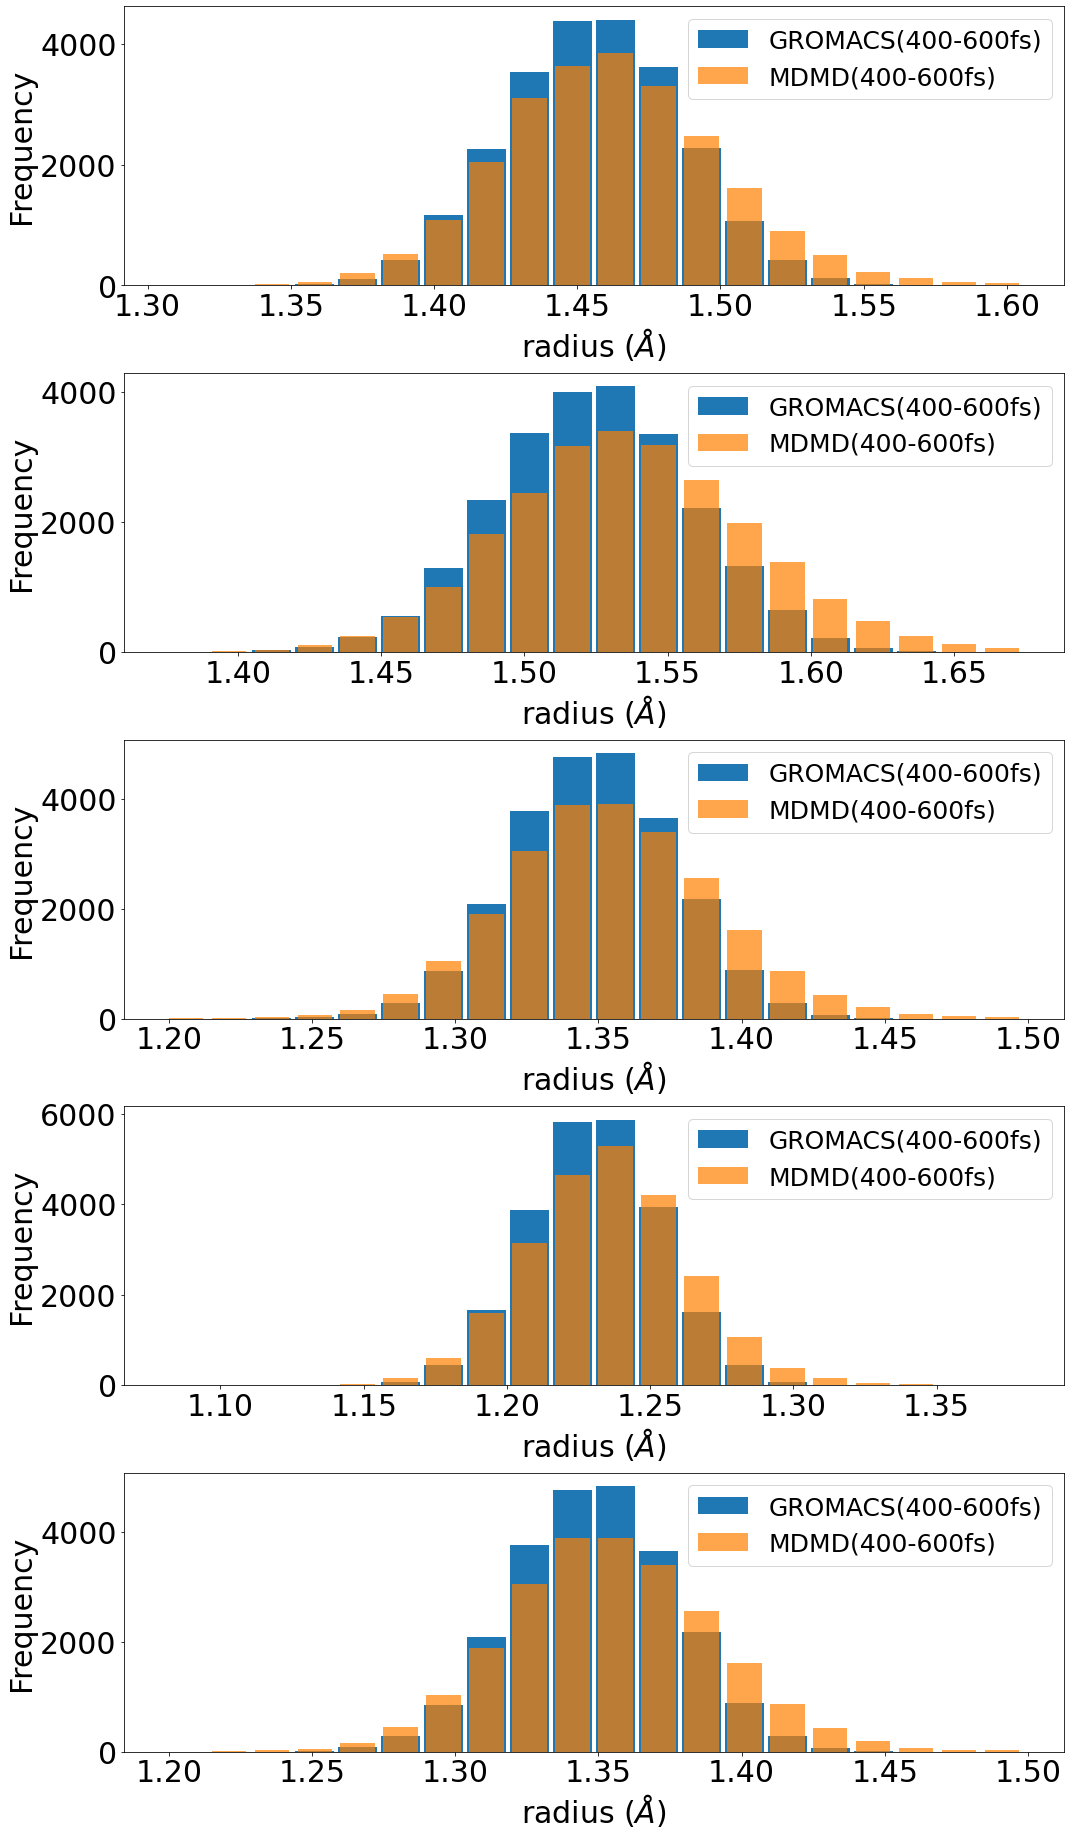

In [31]:
double_plot_radiuses_hist(acttrj, prdtrj, residue_list=residue_list)
# double_plot_radiuses_hist(acttrj, prdtrj)

## each time

In [32]:
def plot_each_radius(trj1, trj2, label1, label2, sp1, sp2, meanstd="mean", axis=1, snapshots=[200, 300]):
    fig = plt.figure(figsize=(20,5))
    fig.add_subplot(1, 1, 1)

    if meanstd == "mean":
        degree_list1 = cal_radius_arr(trj1, sp1, sp2).mean(axis=axis).tolist()
        if axis == 1:
            degree_list2 = cal_radius_arr(trj2, sp1, sp2).mean(axis=axis).tolist()
        else:
            degree_list2s = [cal_radius_arr(trj2[[snapshot-1], :, :], sp1, sp2).mean(axis=axis).tolist() for snapshot in snapshots]

    elif meanstd == "std":
        degree_list1 = cal_radius_arr(trj1, sp1, sp2).std(axis=axis).tolist()
        if axis == 1:
            degree_list2 = cal_radius_arr(trj2, sp1, sp2).std(axis=axis).tolist()
        else:
            degree_list2s = [cal_radius_arr(trj2[[snapshot], :, :], sp1, sp2).std(axis=axis).tolist() for snapshot in snapshots]
            
    if axis==1:
        print(np.argsort(degree_list2)[::-1][:30])
        plt.plot(list(range(len(degree_list2))), degree_list2, label=f"{label2}(0-{len(trj2)*2}fs)", lw=3, color='C1')
    else:
        c = 0
        for snapshot, degree_list2 in zip(snapshots, degree_list2s):
            print(np.argsort(degree_list2)[::-1][:30])
            if c == 1:
                plt.plot(list(range(len(degree_list2))), degree_list2, label=f"{label2}({snapshot*2}fs)", color='red', lw=3)
            else:
                plt.plot(list(range(len(degree_list2))), degree_list2, label=f"{label2}({snapshot*2}fs)", lw=3, color='C1')
            c += 1

    if axis==0:
        plt.plot(list(range(1, len(degree_list1)+1)), degree_list1, label=f"{label1}(0-{len(trj1)*2}fs)", lw=3, color='C0')
    else:
        plt.plot(list(range(len(degree_list1))), degree_list1, label=f"{label1}(0-{len(trj1)*2}fs)", lw=3, color='C0')
            
    plt.tight_layout()
    
    if meanstd == 'mean':
        plt.ylim(0,)
    
#     plt.title(f"{sp1}-{sp2}")
    
    if axis==0:
        plt.xlabel("residue number", fontsize=30)
    plt.ylabel("bond length ($\AA$)", fontsize=30)

    plt.legend(fontsize=25)
    plt.tick_params(labelsize=25)

In [33]:
axis = 1

### mean

In [34]:
meanstd = "mean"

[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 82 81 83 84 80 79 78 77 76
 75 74 73 72 71 70]


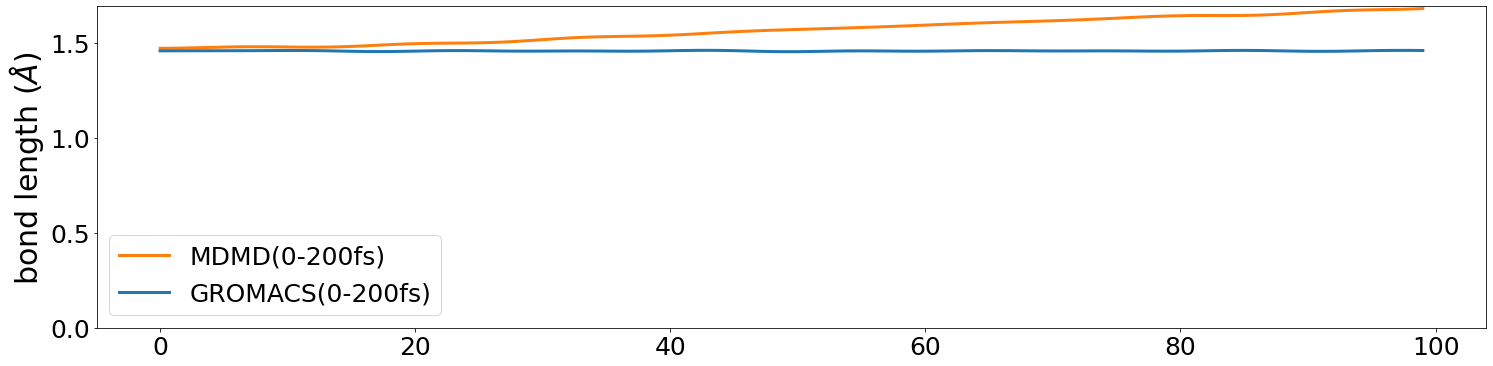

In [35]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'N', meanstd=meanstd, axis=axis, snapshots=snapshots)

[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76
 75 74 73 72 71 70]


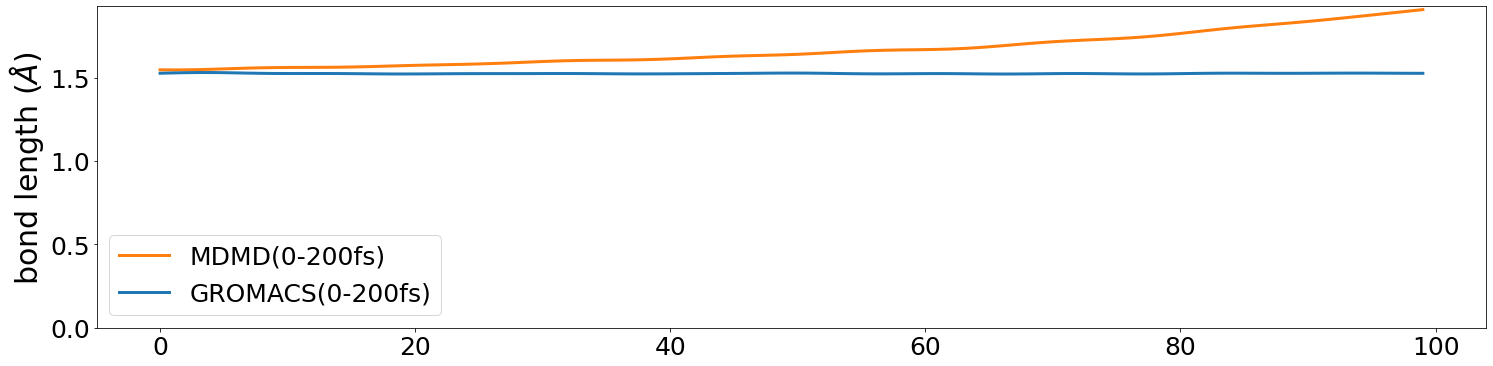

In [36]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'C', meanstd=meanstd, axis=axis, snapshots=snapshots)

[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76
 75 74 73 72 71 70]


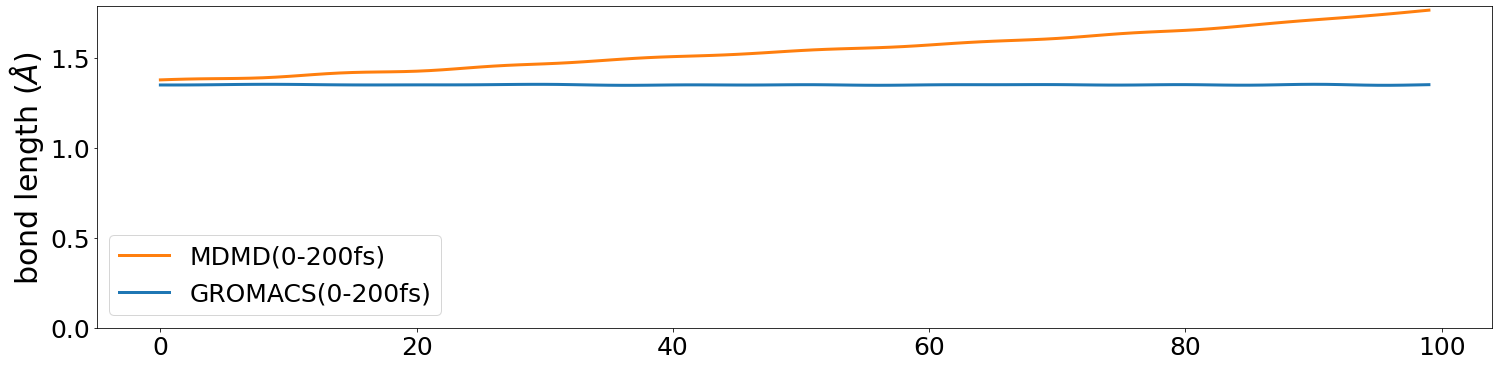

In [37]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'N', 'C', meanstd=meanstd, axis=axis, snapshots=snapshots)

[99 98 97 96 95 89 88 90 87 94 91 92 93 86 85 84 83 82 81 80 79 78 77 76
 75 74 73 72 71 70]


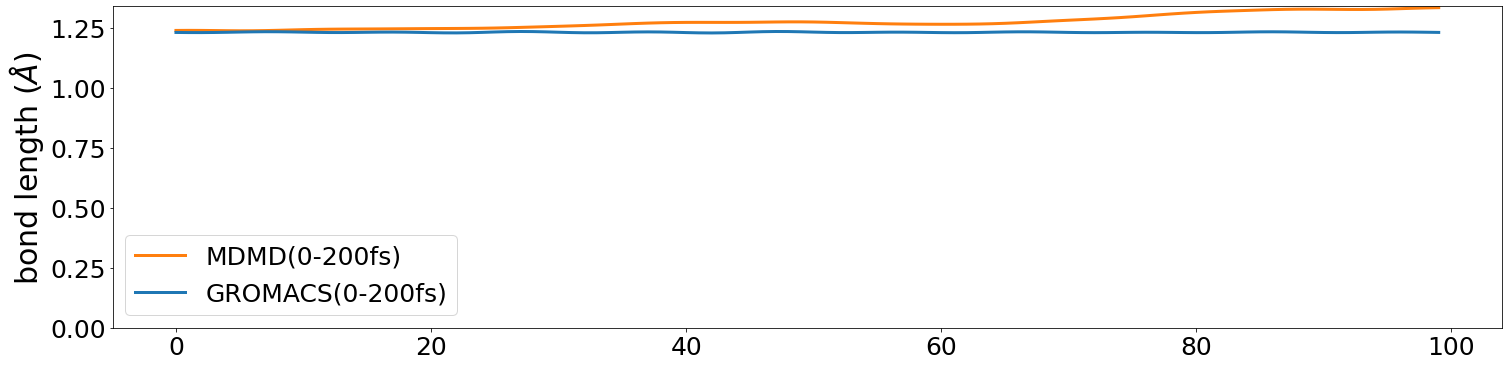

In [38]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'O', meanstd=meanstd, axis=axis, snapshots=snapshots)

[99 98 97 96 95 94 93 92 91 90 89 88 87 86 85 84 83 82 81 80 79 78 77 76
 75 74 73 72 71 70]


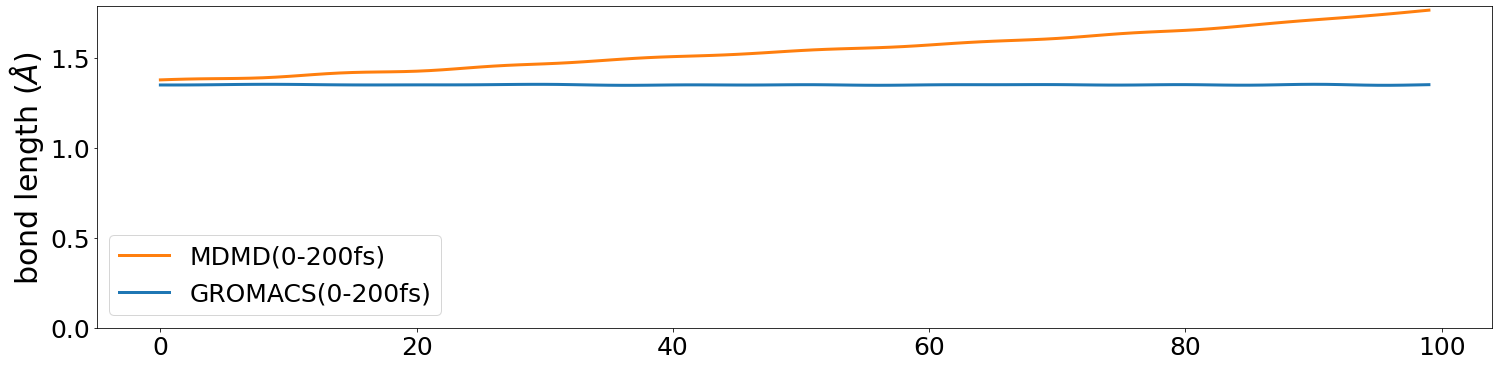

In [39]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'N', meanstd=meanstd, axis=axis, snapshots=snapshots)

## each residue

In [40]:
axis = 0

### mean

In [41]:
meanstd = "mean"

[135 137 136 138 134 140 141 132 133 208 139 211 142 143 131 207  74 209
  73 129 206 212 151  72 130 153 188  85 152 213]
[135 137 136 138 134 140 141 132 133 208 139 211 143 142 209 131 207  74
  73 129 206 212 151  72 130 188 153  85 152 213]


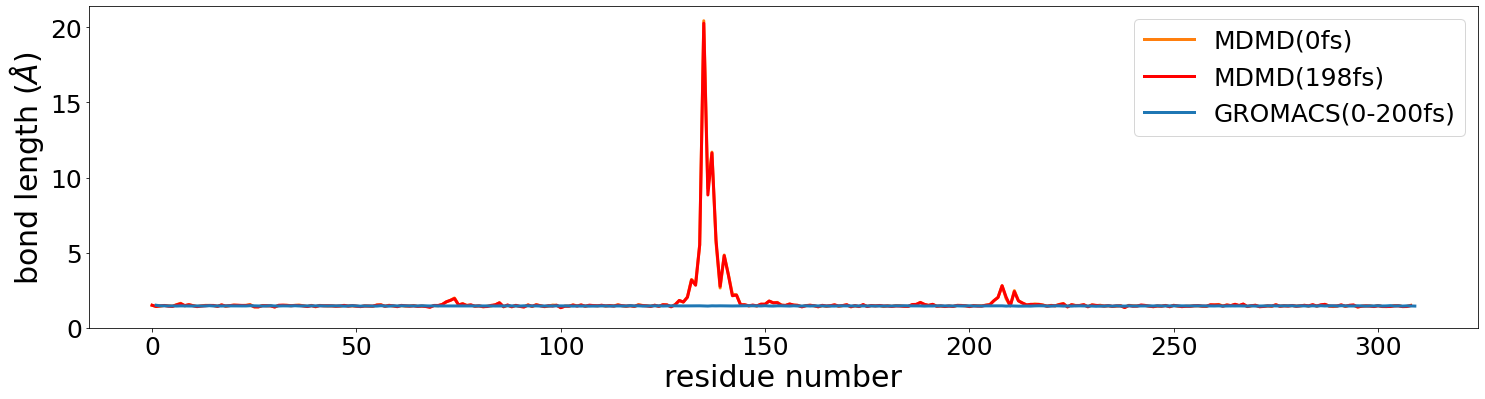

In [42]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'N', meanstd=meanstd, axis=axis, snapshots=snapshots)

[137 138 135 136 134 133 139 131 132 140 209 208 210  73 207 142 141 211
 129 151 206 143 212 130 150  72  75 205 153  84]
[137 138 135 136 134 133 139 131 132 140 209 208 210  73 207 141 211 142
 129 151 206 143 212  75 130  72 150 205  84  74]


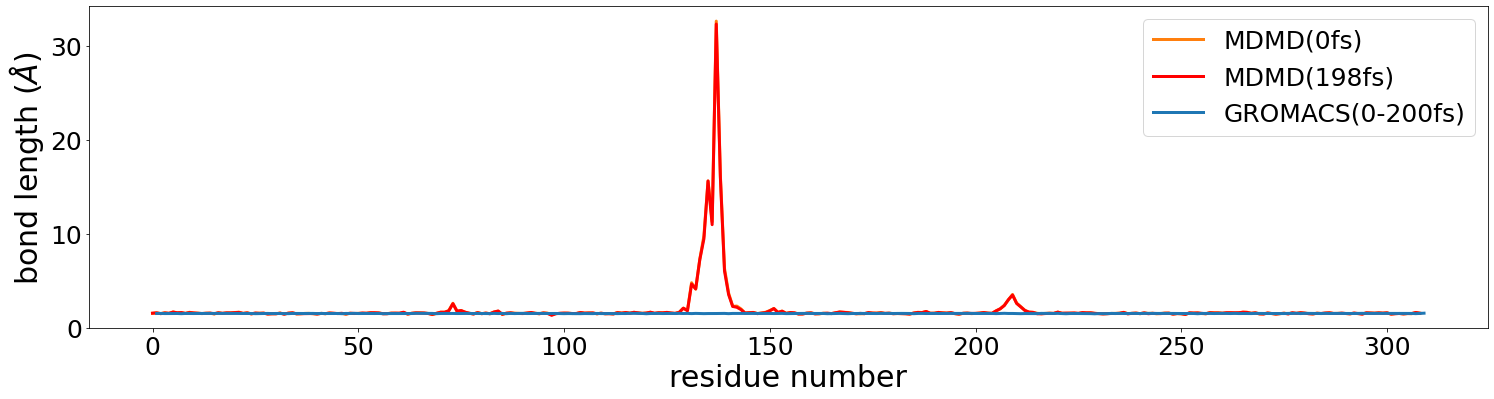

In [43]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'CA', 'C', meanstd=meanstd, axis=axis, snapshots=snapshots)

[136 137 135 134 133 139 131 210 208 140 141 151 142 206  73  72 207 152
 150 205 128 132  71 211 187 129 143 213 220 219]
[136 137 135 134 133 139 131 210 208 140 141 142 151  73 206 152  72 207
 150 205 187 128 211  71 129 143 220 213 219 212]


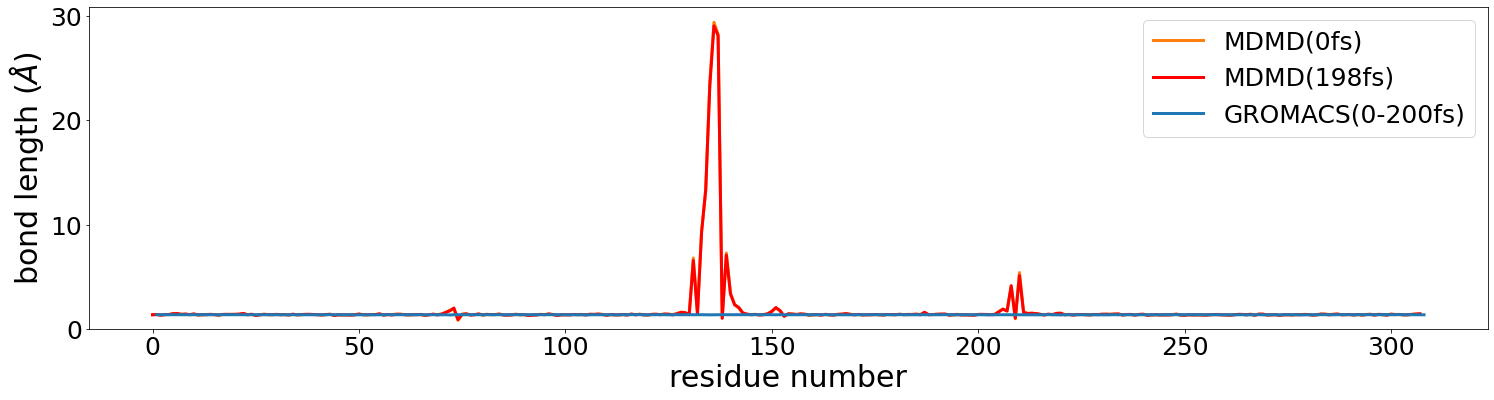

In [44]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'N', 'C', meanstd=meanstd, axis=axis, snapshots=snapshots)

[137 138 135 134 133 131 140  74 209 139 208 210 132 151 206  73 220 153
 117 222   7 261 169 207   5 189 143  22 308 294]
[137 138 135 134 133 140 131  74 209 139 208 210 151 132  73 206 153 220
 117 169 143 207 189 222   5   7 261 290  22  75]


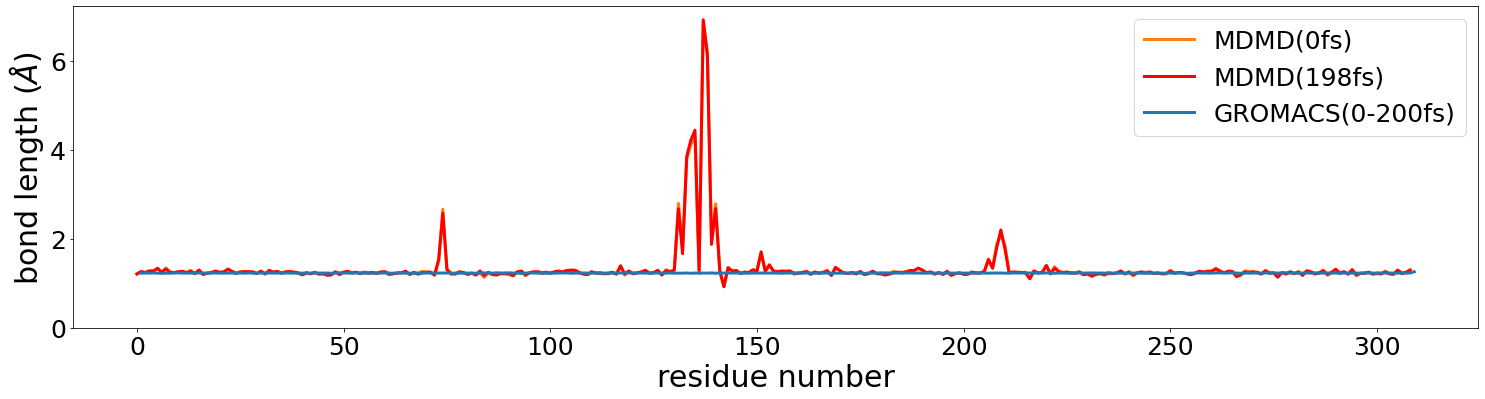

In [45]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'O', meanstd=meanstd, axis=axis, snapshots=snapshots)

[136 137 135 134 133 139 131 210 208 140 141 151 142 206  73  72 207 152
 150 205 128 132  71 211 187 129 143 213 220 219]
[136 137 135 134 133 139 131 210 208 140 141 142 151  73 206 152  72 207
 150 205 187 128 211  71 129 143 220 213 219 212]


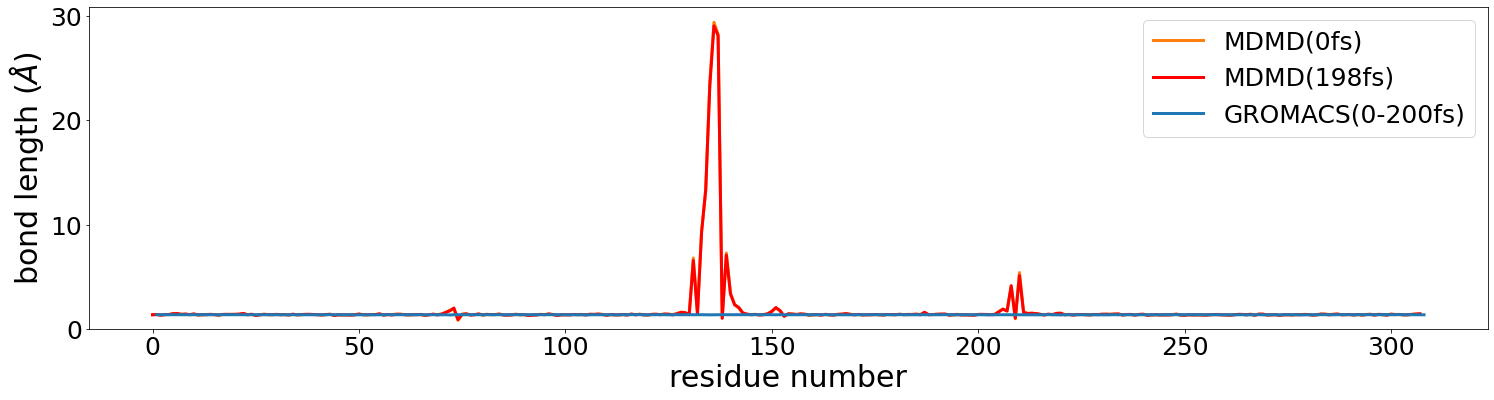

In [46]:
plot_each_radius(acttrj, prdtrj, label1, label2, 'C', 'N', meanstd=meanstd, axis=axis, snapshots=snapshots)

# ADF

In [47]:
def cal_degrees(coords_center, coords2, coords3):
    us = np.subtract(coords2, coords_center)
    vs = np.subtract(coords3, coords_center)
    
    inns = np.inner(us, vs)[0]
    norms = np.sqrt(np.sum(np.square(us), axis=1)) * np.sqrt(np.sum(np.square(vs), axis=1))

    cos_thetas = inns / norms
    degs = np.rad2deg(np.arccos(np.clip(cos_thetas, -1.0, 1.0)))
    return degs

In [48]:
approved_species_sets = {
    'CA': [set(['N', 'C'])],
    'N': [set(['CA', 'C'])],
    'C': [set(['CA', 'N']), set(['CA', 'O']), set(['N', 'O'])]
}

In [49]:
# def cal_degree_list(trj, center_species, species_set):
#     if species_set not in approved_species_sets[center_species]:
#         print('unapproved species sets')
    
    

#     l, u = SLICE_INDECES[center_species]

#     degree_list = []
#     for i in range(l, u):
#         coords_center = trj[:, i, :]
        
#         try:
#             if center_species == 'C' and species_set == set(['CA', 'N']):
#                 coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
#             elif center_species == 'C' and species_set == set(['O', 'N']):
#                 coords2 = trj[:, ADJACENT_INDECES[i][1][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
#             else:
#                 coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
#                 coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
#         except IndexError:
#             continue

#         degree_list.extend(cal_degrees(coords_center, coords2, coords3).flatten().tolist())
        
#     return degree_list

def cal_degree_arr(trj, center_species, species_set):
    if species_set not in approved_species_sets[center_species]:
        print('unapproved species sets')

    l, u = SLICE_INDECES[center_species]

    degree_list = []
    for i in range(l, u):
        coords_center = trj[:, i, :]
        
        try:
            if center_species == 'C' and species_set == set(['CA', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            elif center_species == 'C' and species_set == set(['O', 'N']):
                coords2 = trj[:, ADJACENT_INDECES[i][1][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][1], :]
            elif center_species == 'N' and species_set == set(['CA', 'C']):
                coords2 = trj[:, ADJACENT_INDECES[i][0][1], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
            else:
                coords2 = trj[:, ADJACENT_INDECES[i][0][0], :]
                coords3 = trj[:, ADJACENT_INDECES[i][1][0], :]
        except IndexError:
            continue

        degree_list.append(cal_degrees(coords_center, coords2, coords3).flatten().tolist())
        
    return np.array(degree_list).transpose(1, 0)

In [50]:
N_FIGS = sum([len(li) for li in approved_species_sets.values()])

In [51]:
N_BINS = 30

def plot_adf(trj):
    fig = plt.figure(figsize=(20,5*N_FIGS))

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            i += 1
            fig.add_subplot(N_FIGS, 1, i)

            degree_list = cal_degree_list(trj, species, spset)
            hist, bins = np.histogram(degree_list, bins=N_BINS)

            plt.bar([(bins[i+1]+bins[i])/2 for i in range(len(hist))], hist)

            plt.xlabel("angle (degrees)", fontsize=14)
            plt.ylabel("Frequency", fontsize=14)

            sp1, sp2 = spset
            plt.title(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list)))})", fontsize=14)
            plt.tight_layout()

In [52]:
def plot_adf_double(trj1, trj2, label1, label2):
    fig = plt.figure(figsize=(20,5*N_FIGS*2))

    i = 0
    for species, spset_list in approved_species_sets.items():
        for spset in spset_list:
            
            degree_arr1 = cal_degree_arr(trj1, species, spset)
            degree_arr2= cal_degree_arr(trj2, species, spset)
            
            degree_list1 = degree_arr1.flatten().tolist()
            degree_list2 = degree_arr2.flatten().tolist()
            
            binmax = max(degree_list1 + degree_list2)
            binmin = min(degree_list1 + degree_list2)

           # trj1
            i += 1
            fig.add_subplot(N_FIGS*2, 1, i)

            plt.hist(degree_list1, range=(binmin, binmax), bins=N_BINS, label=label1, rwidth=0.9)

            sp1, sp2 = spset
            print(f"{sp1}-{species}-{sp2} (mean: {int(round(np.mean(degree_list1)))}, std: {round(np.std(degree_list1),2)}) (mean: {int(round(np.mean(degree_list2)))}, std: {round(np.std(degree_list2),2)})")
            
            # trj2    
            plt.hist(degree_list2, range=(binmin, binmax), bins=N_BINS, color="#ff7f00", label=label2, alpha=0.7, rwidth=0.8)
            

            plt.xlabel("angle (degrees)", fontsize=30)
            plt.ylabel("Frequency", fontsize=30)
            plt.tick_params(labelsize=25)
            
            plt.legend(fontsize=25)
    
    plt.tight_layout()

In [53]:
# def plot_each_adf_mean(trj):
#     fig = plt.figure(figsize=(20,3*N_FIGS))

#     i = 0
#     for species, spset_list in approved_species_sets.items():
#         for spset in spset_list:
#             i += 1
#             fig.add_subplot(N_FIGS, 1, i)

#             degree_list = cal_degree_list(trj, species, spset)
#             hist, bins = np.histogram(degree_list, bins=N_BINS)

#             degree_list_each_time = [cal_degree_list(trj[[t], :, :], species, spset) for t in range(trj.shape[0])]
#             mean_angle_each_time = [np.mean(degree_list) for degree_list in degree_list_each_time]

#             plt.plot(list(range(trj.shape[0])), mean_angle_each_time)
#             plt.scatter(list(range(trj.shape[0])), mean_angle_each_time)

#             sp1, sp2 = spset
#             plt.title(f"{sp1}-{species}-{sp2}")
#             plt.tight_layout()

In [54]:
def plot_each_adf(trj1, trj2, label1, label2, species, spset, meanstd="mean", axis=1):
    fig = plt.figure(figsize=(10,5))
    fig.add_subplot(1, 1, 1)
    
    sp1, sp2 = spset

    if meanstd == "mean":
        degree_list1 = cal_degree_arr(trj1, species, spset).mean(axis=axis).tolist()
        degree_list2 = cal_degree_arr(trj2, species, spset).mean(axis=axis).tolist()
    elif meanstd == "std":
        degree_list1 = cal_degree_arr(trj1, species, spset).std(axis=axis).tolist()
        degree_list2 = cal_degree_arr(trj2, species, spset).std(axis=axis).tolist()

    sp1, sp2 = spset
    
    if axis == 1:
        xs = np.array(range(len(degree_list1))) * 2
    else:
        xs = np.array(range(len(degree_list1)))

    plt.plot(xs, degree_list1, label=label1)
    plt.plot(xs, degree_list2, label=label2)
    plt.tight_layout()
    
    plt.title(f"{sp1}-{species}-{sp2}")
    
    if axis==1:
        plt.xlabel("time (fs)", fontsize=30)
    else:
        plt.xlabel("residue number", fontsize=30)
    plt.ylabel("Std (degrees)", fontsize=30)

    plt.tick_params(labelsize=25)
    plt.legend(fontsize=25)

## double whole time

N-CA-C (mean: 113, std: 4.66) (mean: 112, std: 11.3)
C-N-CA (mean: 124, std: 3.9) (mean: 124, std: 13.98)
N-C-CA (mean: 118, std: 3.75) (mean: 115, std: 12.42)
CA-C-O (mean: 121, std: 4.21) (mean: 120, std: 12.91)
N-C-O (mean: 120, std: 3.91) (mean: 119, std: 14.39)


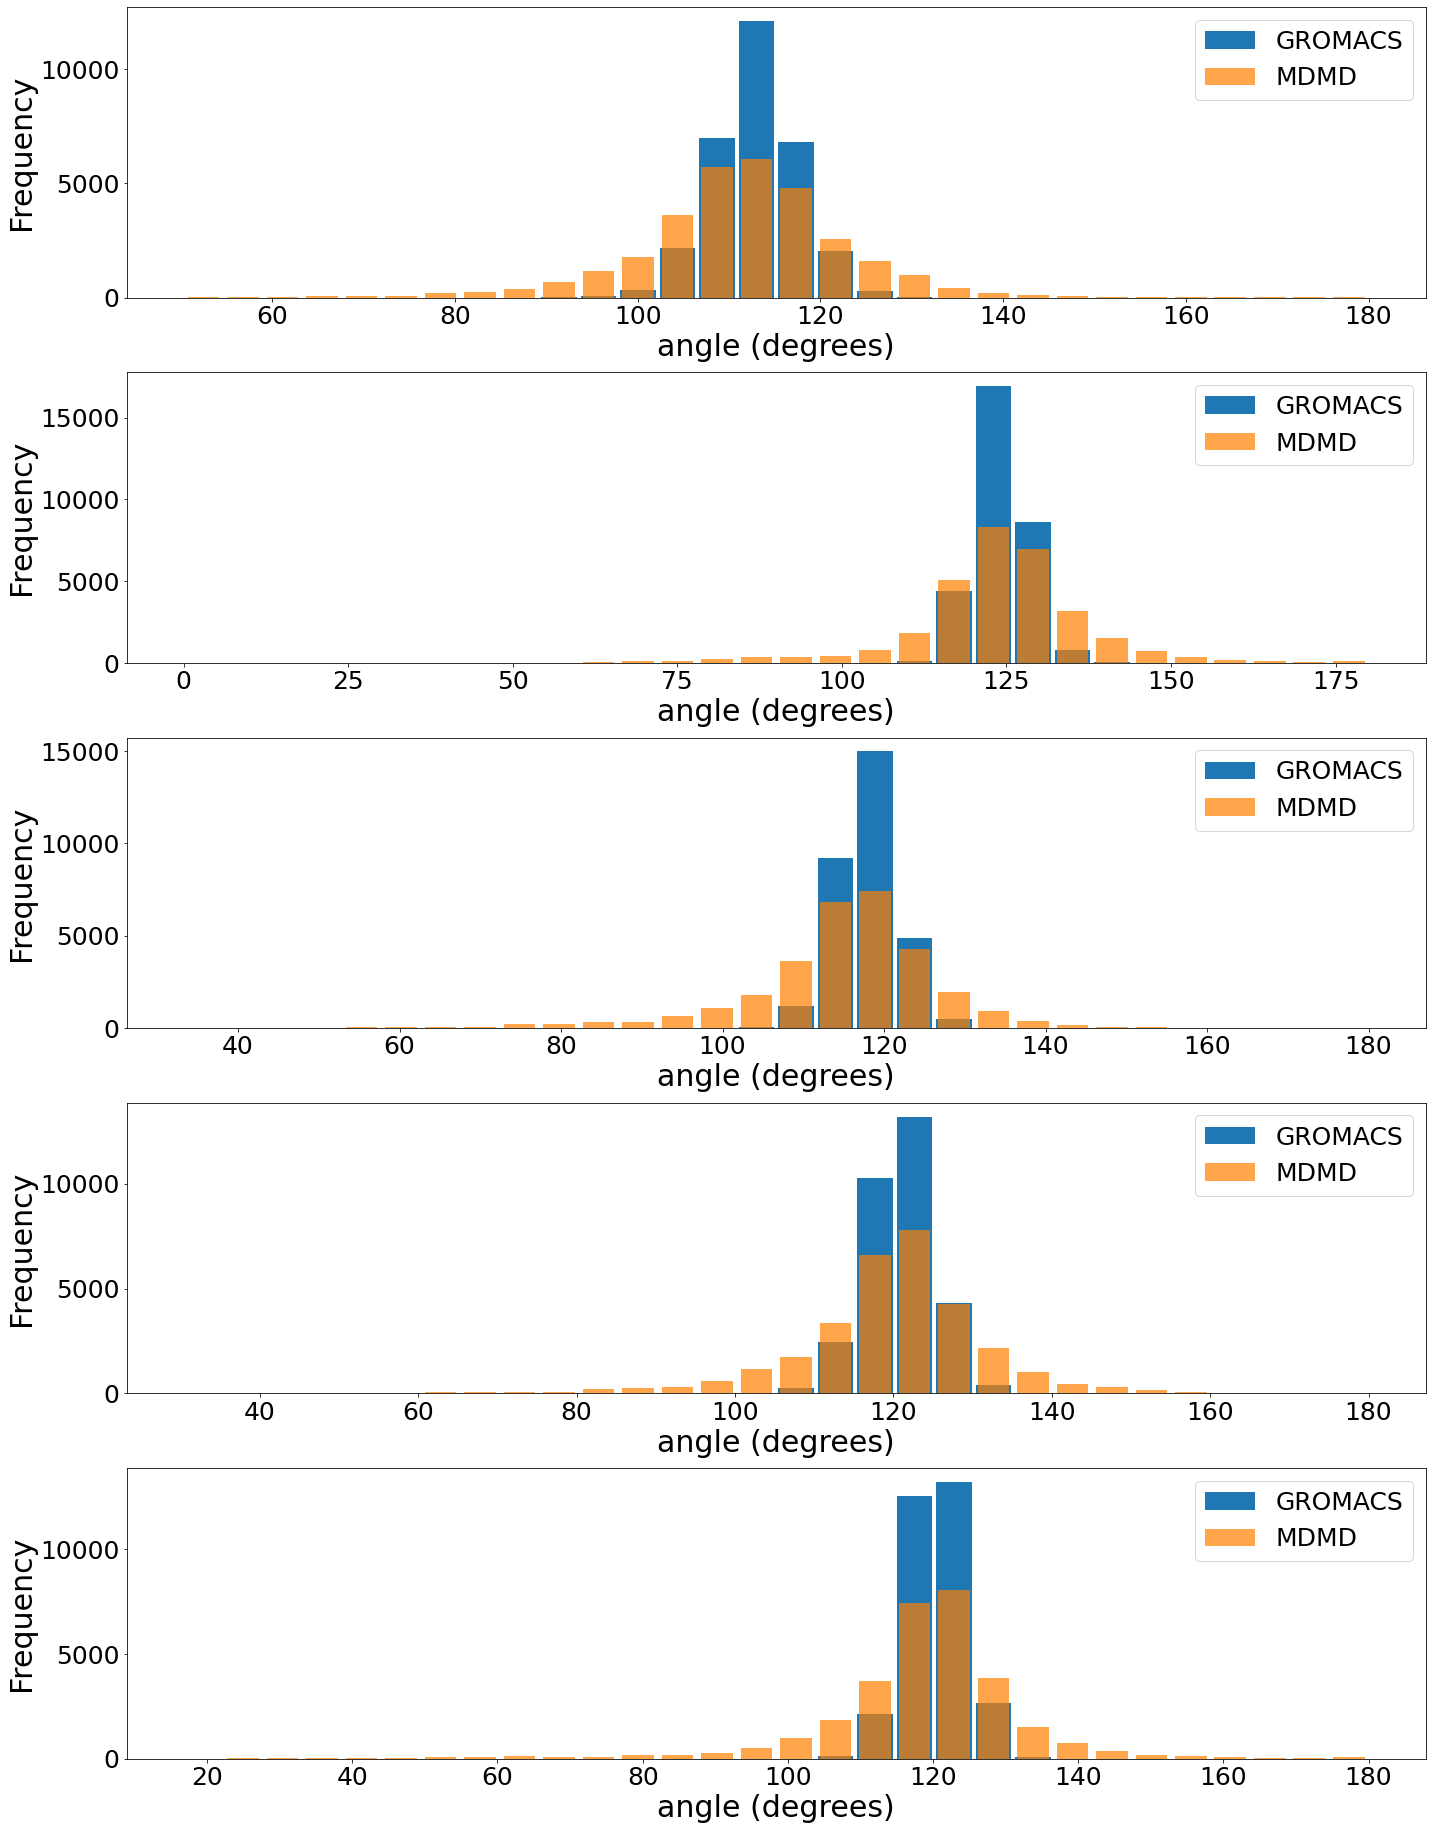

In [55]:
plot_adf_double(acttrj, prdtrj, label1, label2)

## each time

In [56]:
axis=1

### mean

In [57]:
meanstd = "mean"

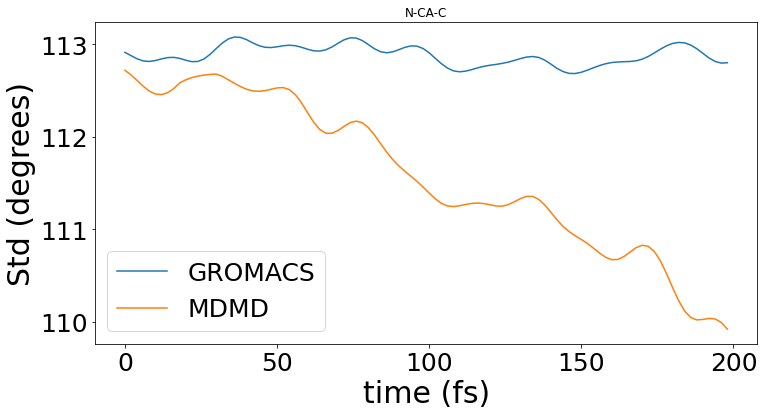

In [58]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

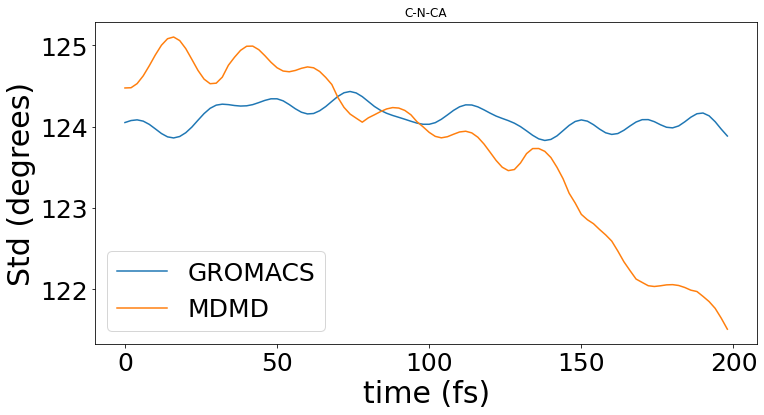

In [59]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

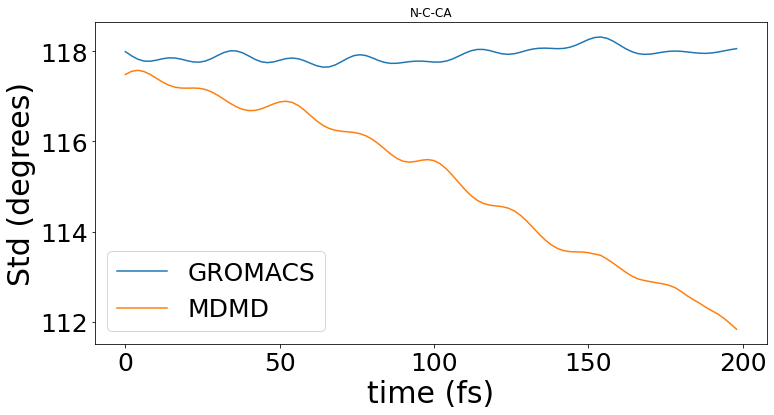

In [60]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

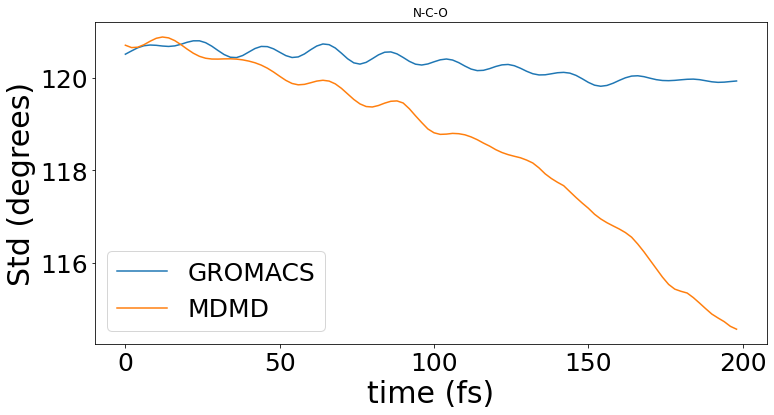

In [61]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

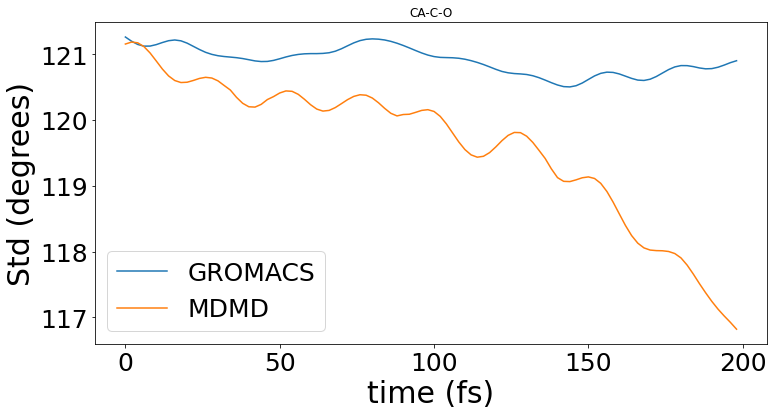

In [62]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

### std

In [63]:
meanstd = "std"

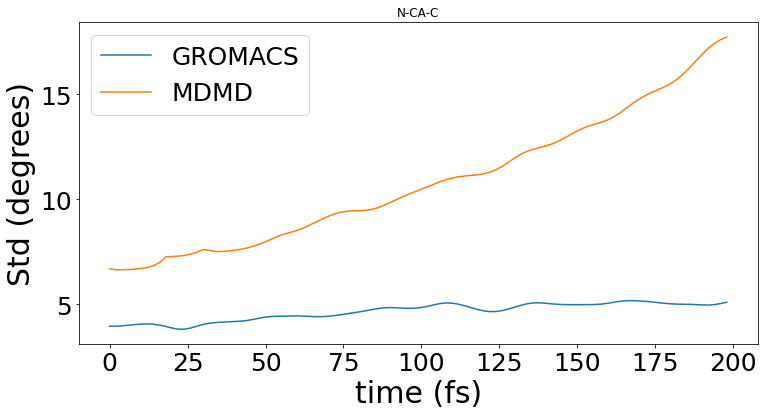

In [64]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

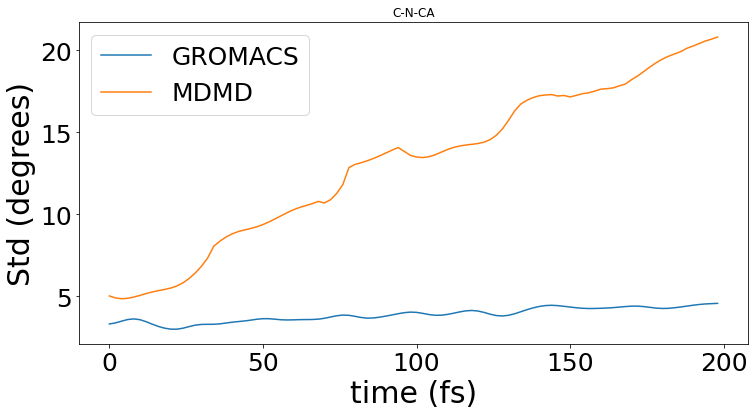

In [65]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

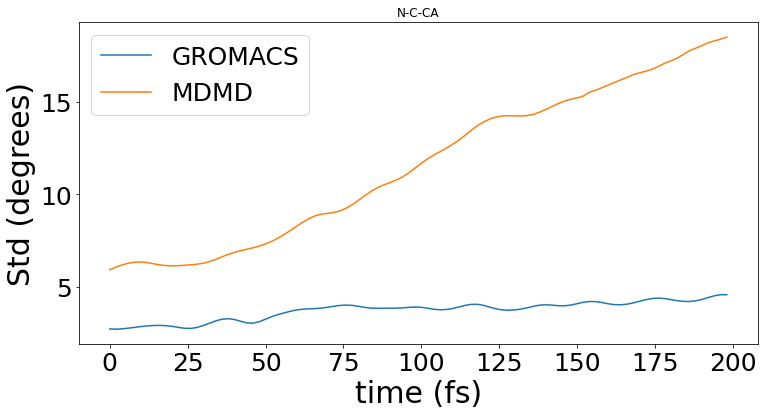

In [66]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

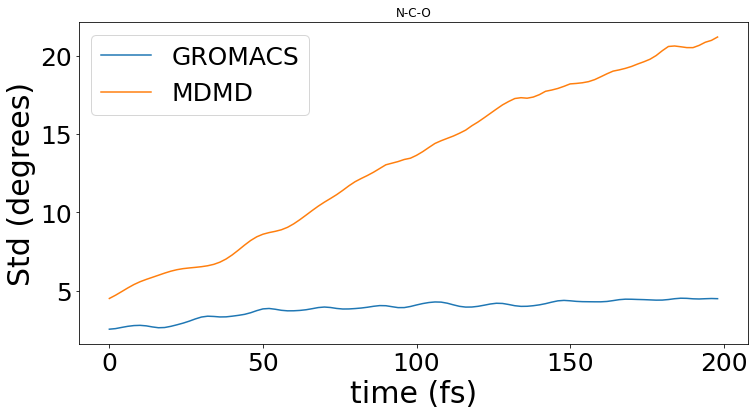

In [67]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

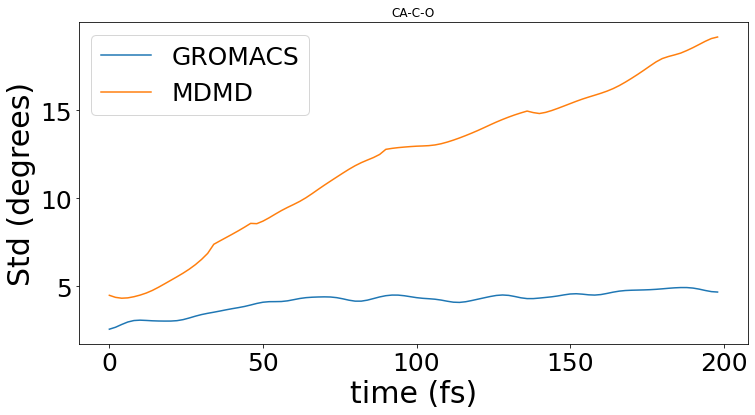

In [68]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

## each residue

In [69]:
axis=0

### mean

In [70]:
meanstd = "mean"

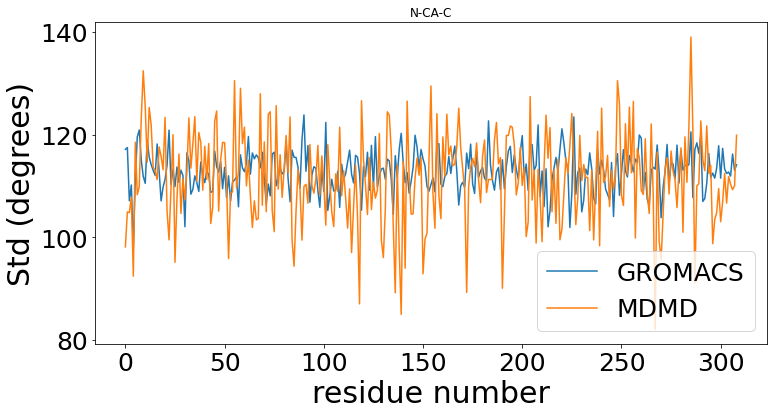

In [71]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

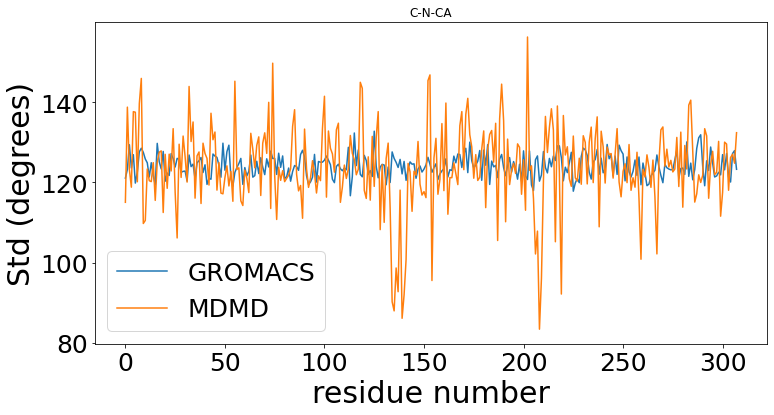

In [72]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

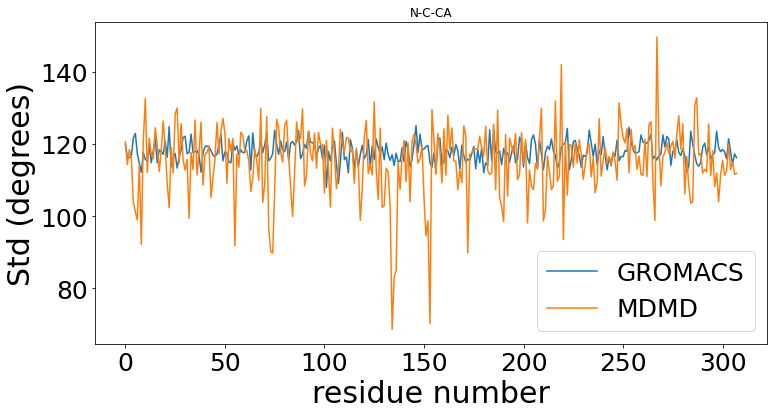

In [73]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

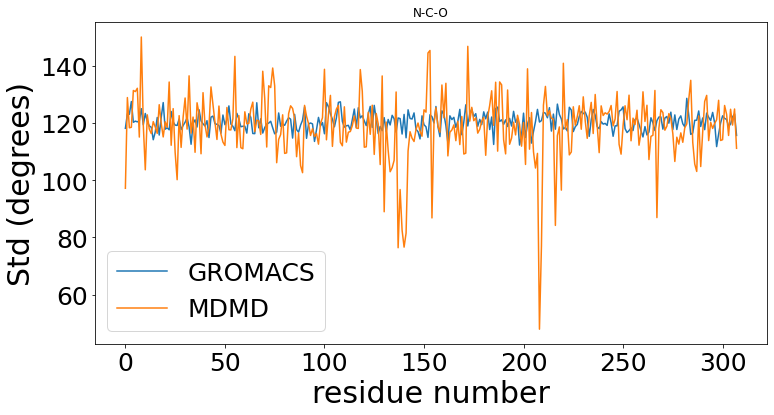

In [74]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

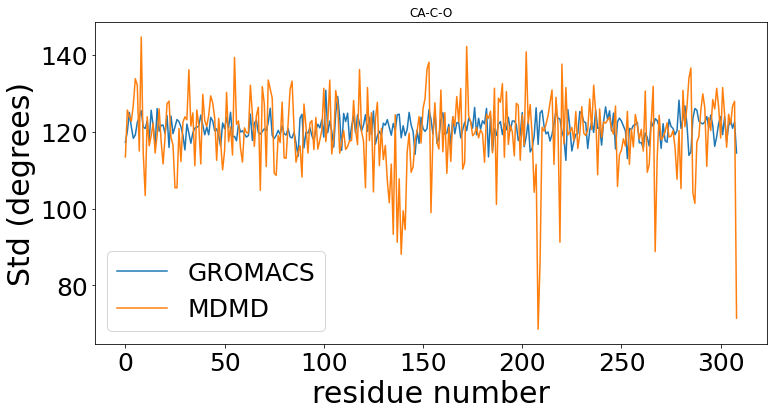

In [75]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

### std

In [76]:
meanstd = "std"

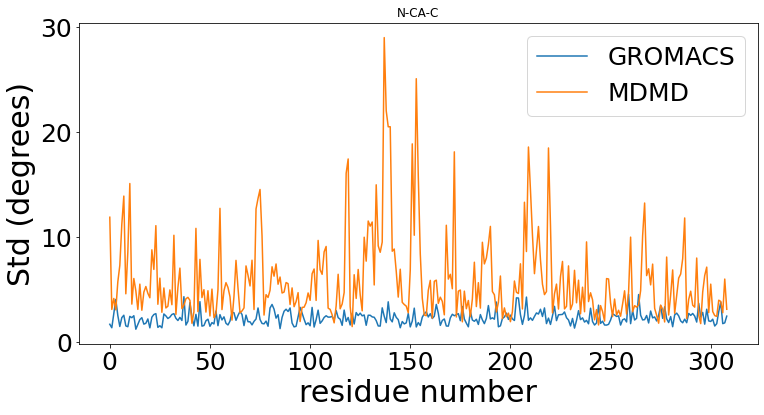

In [77]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'CA', {'N', 'C'}, meanstd=meanstd, axis=axis)

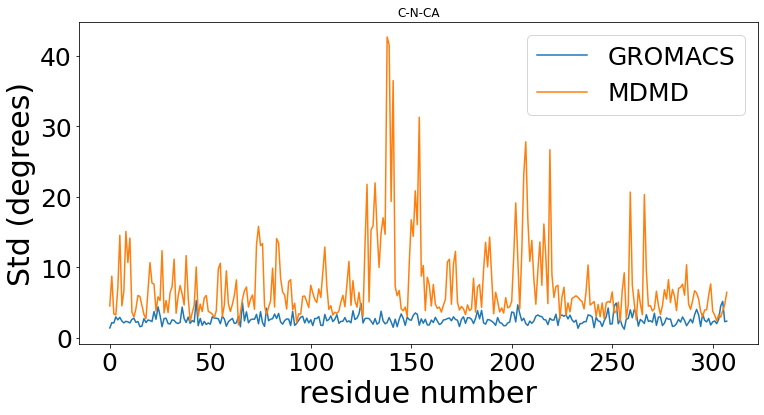

In [78]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'N', {'CA', 'C'}, meanstd=meanstd, axis=axis)

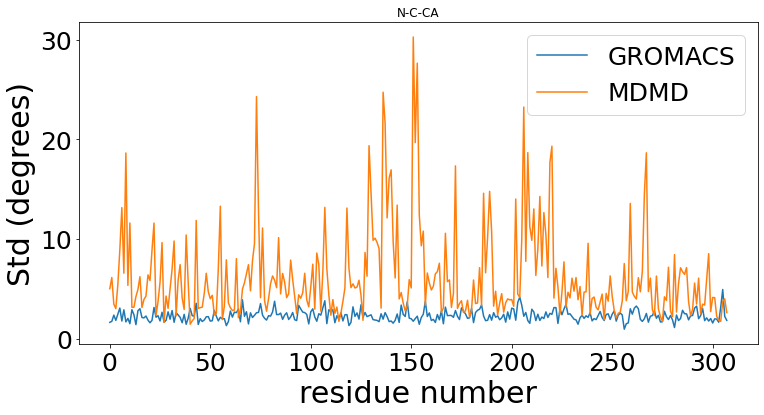

In [79]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'N', 'CA'}, meanstd=meanstd, axis=axis)

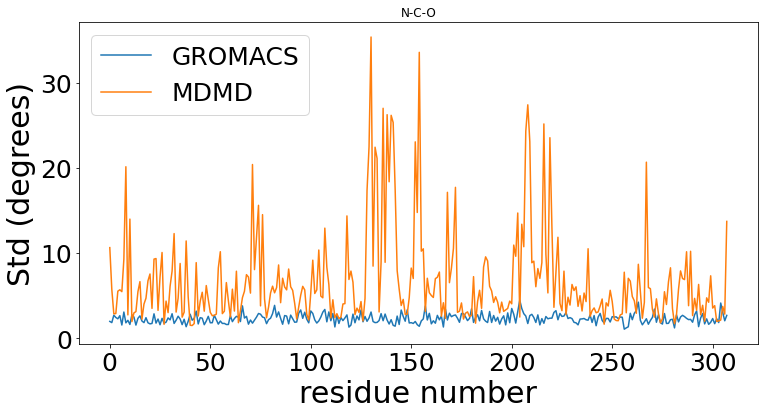

In [80]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'N'}, meanstd=meanstd, axis=axis)

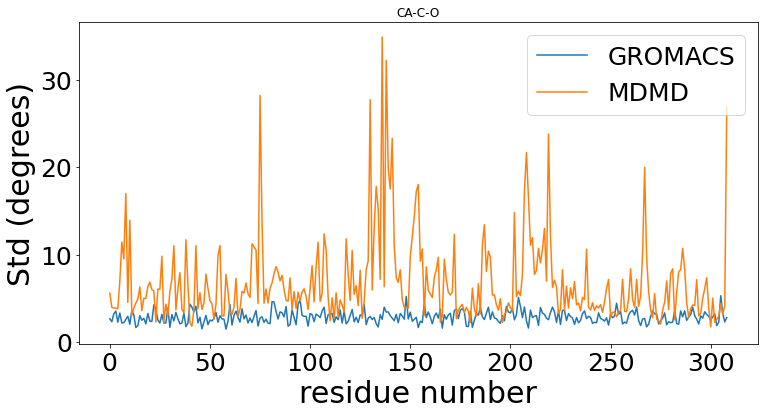

In [81]:
plot_each_adf(acttrj, prdtrj, label1, label2, 'C', {'O', 'CA'}, meanstd=meanstd, axis=axis)

# 二面角

注意！：　必ずrearrangeする

In [82]:
l, u = SLICE_INDECES['N']
N_indeces = [ARRANGED_INDECES[x] for x in range(l, u)]

In [83]:
atom_align = [ATOM_ALIGN[x] for x in REARRANGED_INDECES]

In [84]:
def dihedral(p0, p1, p2, p3): 
    """Praxeolitic formula 
    1 sqrt, 1 cross product""" 
#     p0 = p[0] 
#     p1 = p[1] 
#     p2 = p[2] 
#     p3 = p[3] 

    b0 = -1.0*(p1 - p0) 
    b1 = p2 - p1 
    b2 = p3 - p2 

    # normalize b1 so that it does not influence magnitude of vector 
    # rejections that come next 
    b1 = np.divide(b1, np.linalg.norm(b1))

    # vector rejections 
    # v = projection of b0 onto plane perpendicular to b1 
    # = b0 minus component that aligns with b1 
    # w = projection of b2 onto plane perpendicular to b1 
    # = b2 minus component that aligns with b1 
    v = b0 - np.dot(b0, b1)*b1 
    w = b2 - np.dot(b2, b1)*b1 

    # angle between v and w in a plane is the torsion angle 
    # v and w may not be normalized but that's fine since tan is y/x 
    x = np.dot(v, w) 
    y = np.dot(np.cross(b1, v), w) 
    return np.degrees(np.arctan2(y, x)) 

In [85]:
dihedral(
    np.array([1,1,0]),
    np.array([1,0,0]),
    np.array([0,0,0]),
    np.array([1/2,-1/2,1])
)

-116.56505117707799

In [86]:
def cal_normal_vector(coord1, coord2, coord3):
    u = coord2 - coord1
    v = coord3 - coord1
    return np.cross(u, v)

def dihedral2(p0, p1, p2, p3): 
    u = cal_normal_vector(p0, p1, p2)
    v = cal_normal_vector(p1, p2, p3)
    
    inn = np.inner(u, v)
    norm = np.sqrt(np.sum(np.square(u), axis=0)) * np.sqrt(np.sum(np.square(v), axis=0))
    
    cos_thetas = inn / norm
    degs = np.rad2deg(np.arccos(np.clip(cos_thetas, -1.0, 1.0)))
    return degs

In [87]:
# dihedral2(
#     np.array([1,1,0]),
#     np.array([1,0,0]),
#     np.array([0,0,0]),
#     np.array([1/2,-1/2,1])
# )

In [88]:
def cal_3dihedrals(struct):  # このstructはN,CA,CB, C,Oの並びである前提
    phi_list = []
    psi_list = []
    omega_list = []
    for i in N_indeces[1:-1]:
        phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+3]))
        psi_list.append(dihedral(struct[i], struct[i+1], struct[i+3], struct[i+5]))
        omega_list.append(dihedral(struct[i-4], struct[i-2], struct[i], struct[i+1]))
#         if atom_align[i+2] == "CB":
#             phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+3]))
#             psi_list.append(dihedral(struct[i], struct[i+1], struct[i+3], struct[i+5]))
#             omega_list.append(dihedral(struct[i-4], struct[i-2], struct[i], struct[i+1]))
#         elif atom_align[i+2] == "C":
#             phi_list.append(dihedral(struct[i-2], struct[i], struct[i+1], struct[i+2]))
#             psi_list.append(dihedral(struct[i], struct[i+1], struct[i+2], struct[i+4]))
#             omega_list.append(dihedral(struct[i-3], struct[i-2], struct[i], struct[i+1]))

    return phi_list, psi_list, omega_list

In [89]:
def dihedral_eachtime(trj):
    trj = trj[:, REARRANGED_INDECES, :]
    phi_list, psi_list, omega_list = [], [], []
    for t in range(trj.shape[0]):
        phi, psi, omega = cal_3dihedrals(trj[t])
        phi_list.append(phi)
        psi_list.append(psi)
        omega_list.append(omega)
    
    return np.array(phi_list), np.array(psi_list), np.array(omega_list)

    plt.scatter(np.array(phi_list), psi_list)

In [90]:
def ramachandran_plot(phi_array, psi_array, alpha=0.1, color=None):
    fig = plt.figure(figsize=(10,10))
    fig.add_subplot(1, 1, 1)

    x = phi_array.flatten()
    y = psi_array.flatten()
    plt.scatter(x, y, alpha=alpha, color=color)
    plt.xlim(-180, 180)
    plt.ylim(-180, 180)
    plt.xlabel(u'\u03c6 [degrees]', fontsize=30)
    plt.ylabel(u'\u03c8 [degrees]', fontsize=30)
    
    plt.tick_params(labelsize=25)

In [91]:
def dihedral_hist(arr1, arr2, title):
    title = {"phi": u'\u03c6', 'psi':u'\u03c8', "omega":u'\u03c9'}[title]
    
    arr1 = arr1.flatten().tolist()
    arr2 = arr2.flatten().tolist()
    fig = plt.figure(figsize=(20,10))
            
    binmax = max(arr1 + arr2)
    binmin = min(arr1 + arr2)

   # arr1
    fig.add_subplot(2, 1, 1)

    hist, bins = np.histogram(arr1, range=(binmin, binmax), bins=N_BINS)

    plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist)

    plt.xlabel(f"{title} [degrees]")
    plt.ylabel("Frequency")

#     plt.title(f"{title} (mean: {round(np.mean(arr1), 2)}, std: {round(np.std(arr1), 2)})")
    plt.title(f"{title}")

    # arr2
    fig.add_subplot(2, 1, 2)

    hist, bins = np.histogram(arr2, range=(binmin, binmax), bins=N_BINS)

    plt.bar([f"{int(round((bins[i]+bins[i+1])/2))}" for i in range(len(hist))], hist, color="#ff7f00")

    plt.xlabel(f"{title} [degrees]")
    plt.ylabel("Frequency")

#     plt.title(f"{title} (mean: {round(np.mean(arr2), 2)}, std: {round(np.std(arr2), 2)})")
    plt.title(f"{title}")
    
    plt.tight_layout()

## 計算

In [92]:
phi_array1, psi_array1, omega_array1 = dihedral_eachtime(acttrj)

In [93]:
phi_array2, psi_array2, omega_array2 = dihedral_eachtime(prdtrj)
phi_array2.shape

(100, 307)

## ramachandran

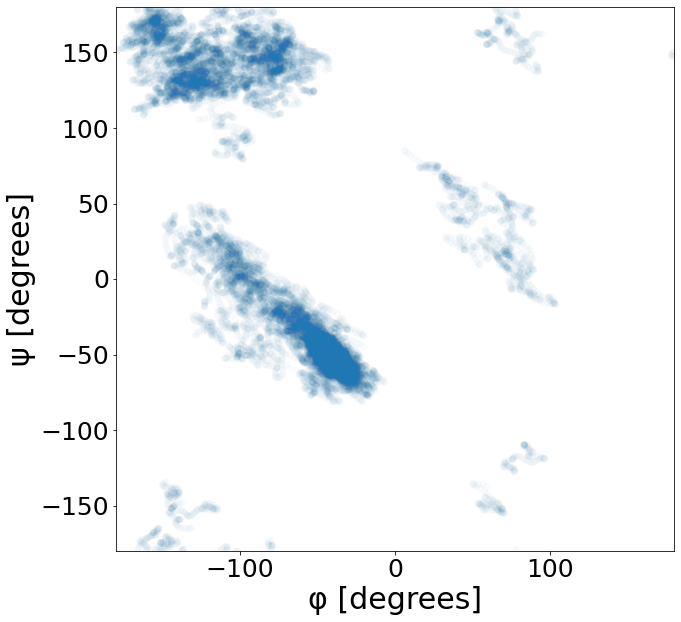

In [94]:
# ramachandran_plot(phi_array1[:, :130], psi_array1[:, :130], alpha=0.02)
ramachandran_plot(phi_array1, psi_array1, alpha=0.02)

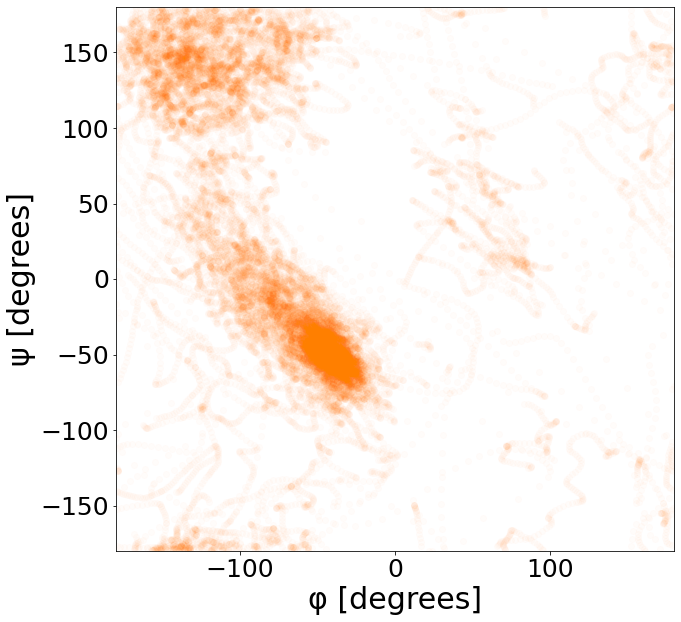

In [95]:
# ramachandran_plot(phi_array2[:, :130], psi_array2[:, :130], alpha=0.02)
ramachandran_plot(phi_array2, psi_array2, alpha=0.02, color="#ff7f00")

## hist

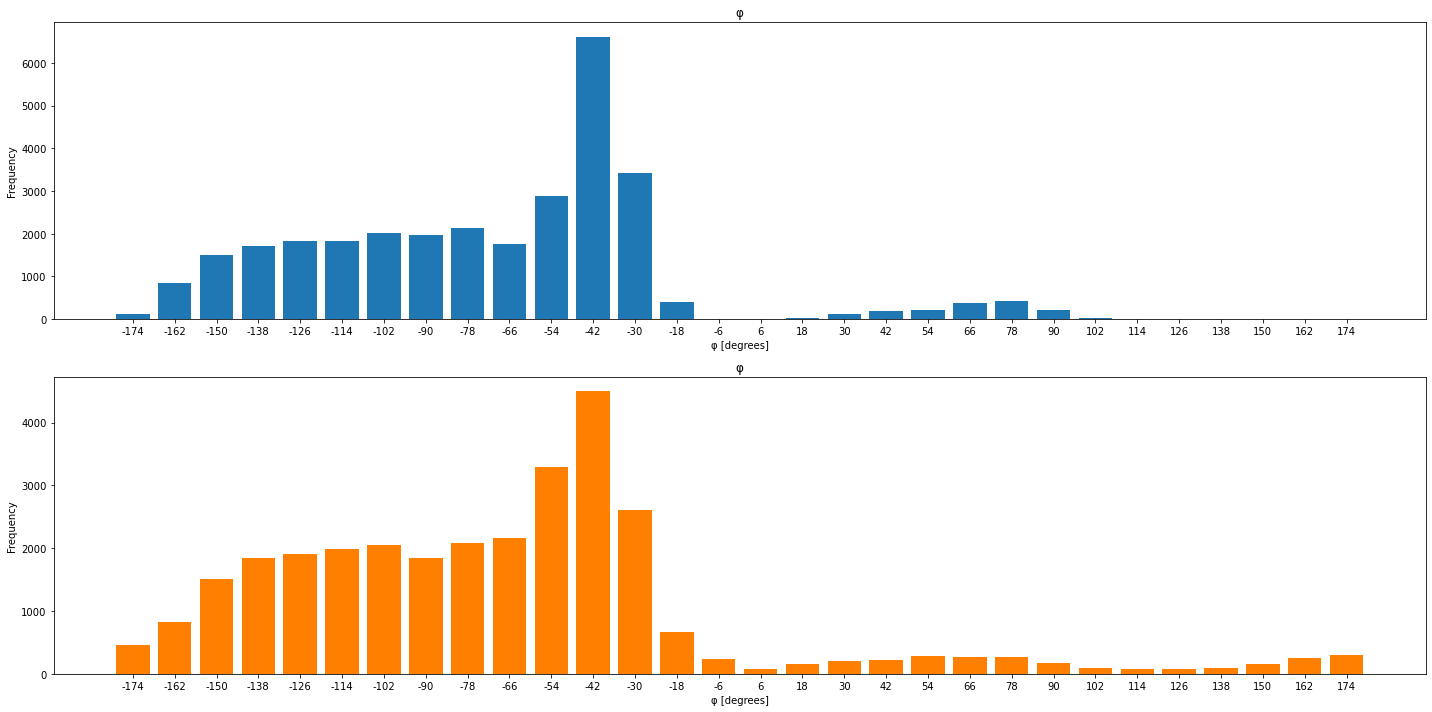

In [96]:
dihedral_hist(phi_array1, phi_array2, "phi")

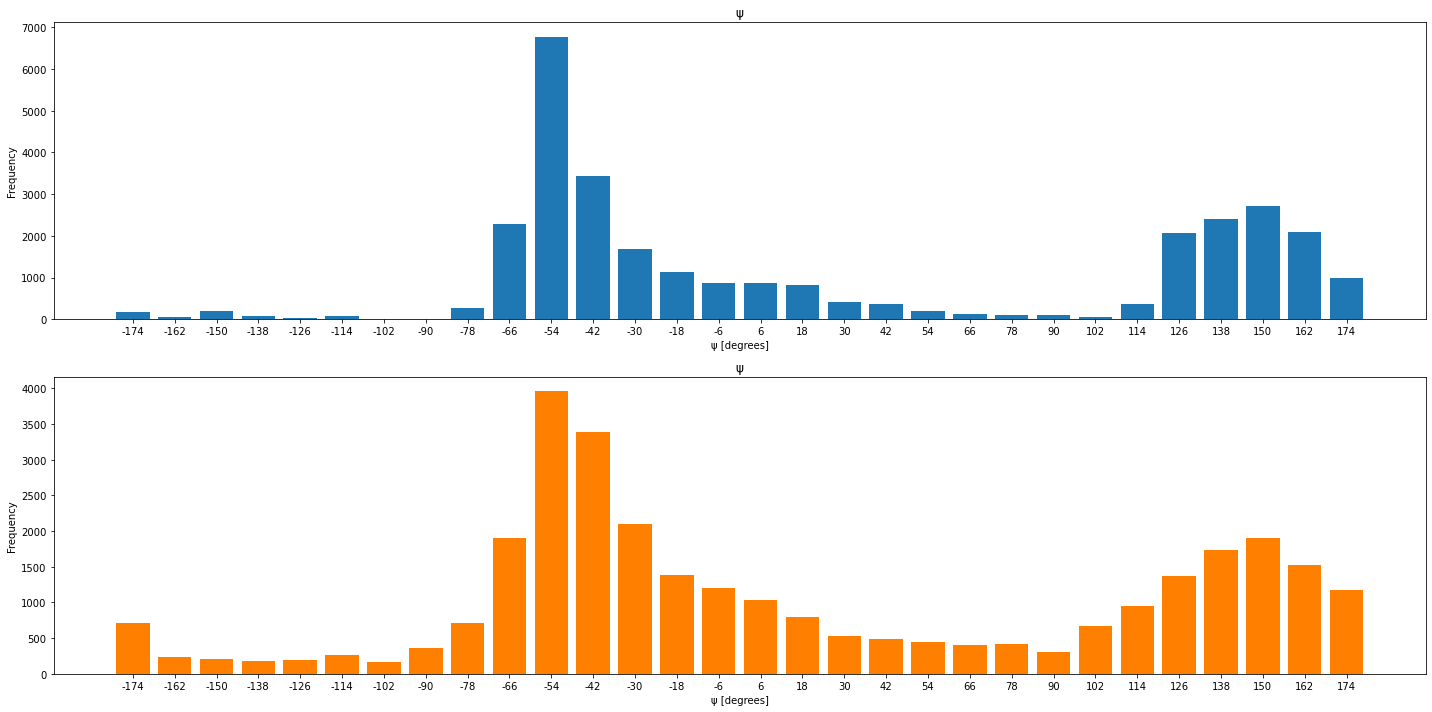

In [97]:
dihedral_hist(psi_array1, psi_array2, "psi")

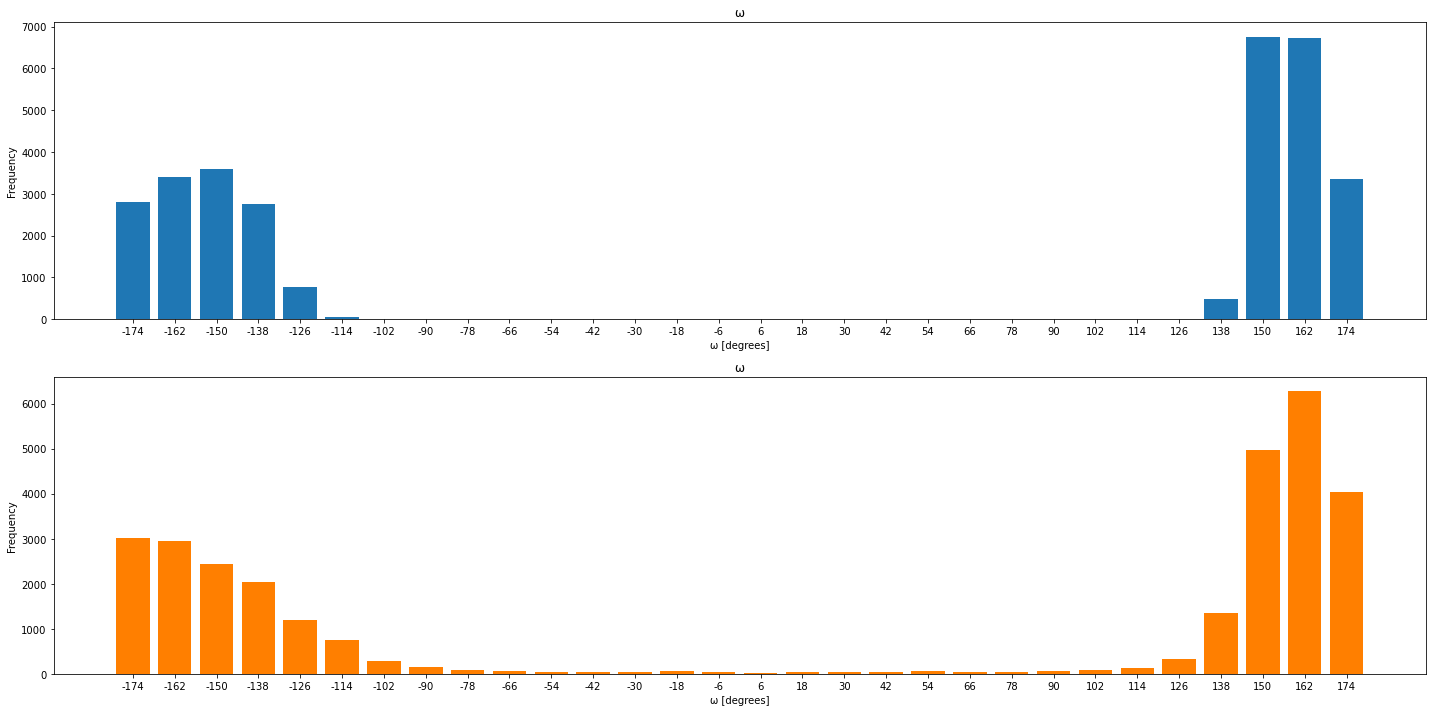

In [98]:
dihedral_hist(omega_array1, omega_array2, "omega")

## mean each residue

In [99]:
np.max(psi_array1)

179.99679509191603

In [100]:
np.min(psi_array2)

-179.9801604214162

In [101]:
axis=0

In [102]:
def dihedral_mean(arr):
    arr = arr.transpose(1, 0)

    for i, arr_residue in enumerate(arr):
        for t in range(arr_residue.shape[0]-1):
            d1, d2 = arr_residue[t:t+2]
            if d1 - d2 >= 180:
                arr_residue[t+1] = d2 + 360
            elif d1 - d2 <= -180:
                arr_residue[t+1] = d2 - 360

#         if np.max(arr_residue) > 180 or np.min(arr_residue) < -180:
#             print(i, np.max(arr_residue), np.min(arr_residue))

        arr[i] = arr_residue
    
    means = arr.mean(axis=1)

    new_means = []
    for m in means:
        if m >=180:
            new_means.append(m-360)
        elif m<=-180:
            new_means.append(m+360)
        else:
            new_means.append(m)
    means = new_means
    
    return means

In [103]:
def dihedral_std(arr):
    arr = arr.transpose(1, 0)

    for i, arr_residue in enumerate(arr):
        for t in range(arr_residue.shape[0]-1):
            d1, d2 = arr_residue[t:t+2]
            if d1 - d2 >= 180:
                arr_residue[t+1] = d2 + 360
            elif d1 - d2 <= -180:
                arr_residue[t+1] = d2 - 360
        arr[i] = arr_residue
    
    return arr.std(axis=1)

In [104]:
# _ = dihedral_mean(psi_array2)

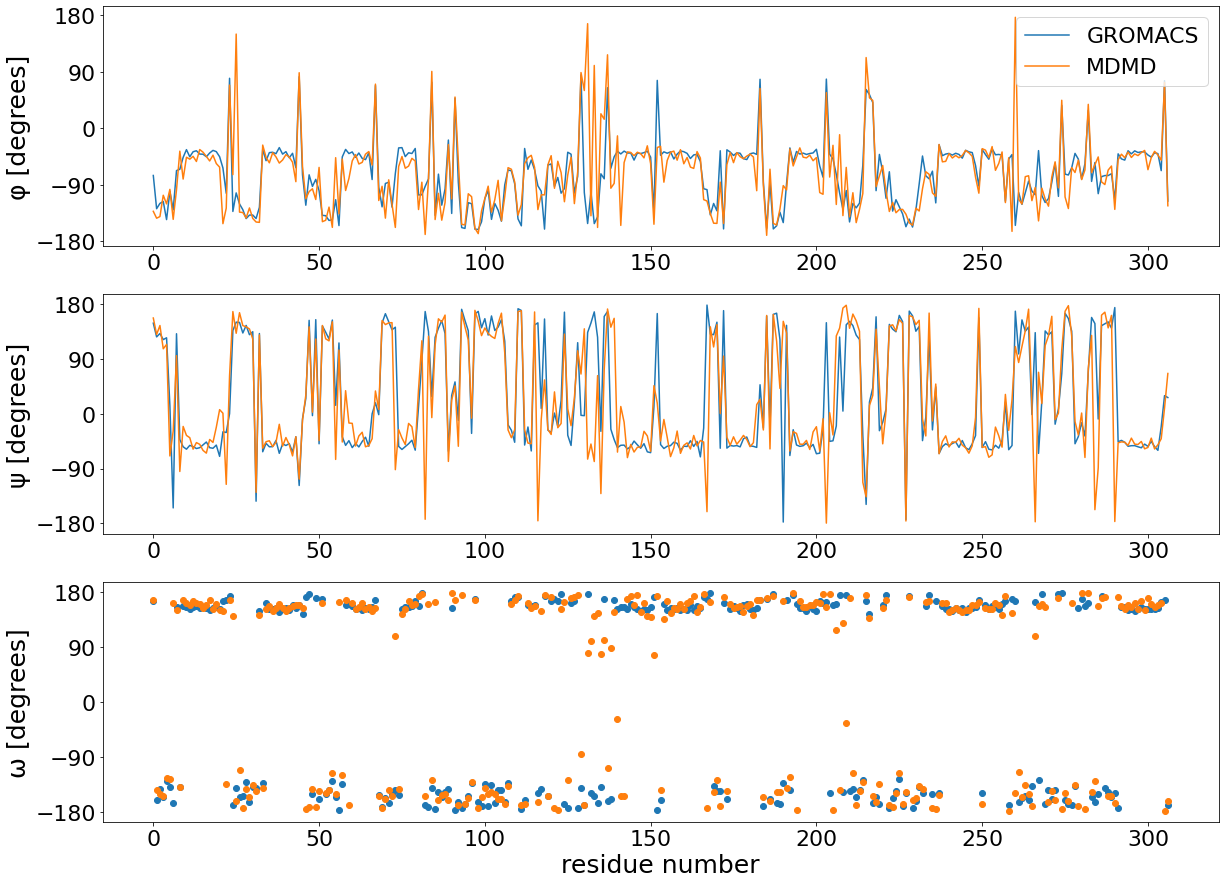

In [105]:
fig = plt.figure(figsize=(20,15))

fig.add_subplot(3, 1, 1)
# li = phi_array1.mean(axis=axis)
li = dihedral_mean(phi_array1.copy())
plt.plot(list(range(len(li))), li, label=label1)
# li = phi_array2.mean(axis=axis)
li = dihedral_mean(phi_array2.copy())
plt.plot(list(range(len(li))), li, label=label2)
# plt.xlabel("residue number")
plt.ylabel(u'\u03c6 [degrees]', fontsize=25)
plt.yticks([-180, -90, 0, 90, 180])
plt.tick_params(labelsize=22)
plt.legend(fontsize=22)

fig.add_subplot(3, 1, 2)
# li = psi_array1.mean(axis=axis)
li = dihedral_mean(psi_array1.copy())
plt.plot(list(range(len(li))), li, label=label1)
# li = psi_array2.mean(axis=axis)
li = dihedral_mean(psi_array2.copy())
plt.plot(list(range(len(li))), li, label=label2)
# plt.xlabel("residue number")
plt.ylabel(u'\u03c8 [degrees]', fontsize=25)
plt.tick_params(labelsize=22)
plt.yticks([-180, -90, 0, 90, 180])

fig.add_subplot(3, 1, 3)
# li = omega_array1.mean(axis=axis)
li = dihedral_mean(omega_array1.copy())
plt.scatter(list(range(len(li))), li, label=label1)
# li = omega_array2.mean(axis=axis)
li = dihedral_mean(omega_array2.copy())
plt.scatter(list(range(len(li))), li, label=label2)
plt.xlabel("residue number", fontsize=25)
plt.ylabel(u'\u03c9 [degrees]', fontsize=25)
plt.yticks([-180, -90, 0, 90, 180])
plt.tick_params(labelsize=22)

## std each residue

[130 133 152 138 137 139 140 132 141  74 154 259 207  21 136 131 153 186
 201 209 208 151 142 167 210 104 220 168 169 134 135 267 150  73  48 118
 124 173 163   5 129 171 278 122  68  58 219  43 211 216]
[140 131  73 151 152 141 208 135 138 132 134 206 139 137 130 133 136  74
 220 186 129 259  21 154  22  72 118   6 207 267 278  20 219 214  48 189
 172 150 201 142  75 163 127 285 169 121   8 200 221   5]
[139 138 140 132 208 131  73 135 151 136 209 207 129 133 206 142 141 211
 134 260 143  74 190 153 267 130 212   0 205 152 173  25 171 137  31 186
 117 118  82  71  54 215  83 222 300 237  75 285 169  89]


Text(0, 0.5, 'ω [degrees]')

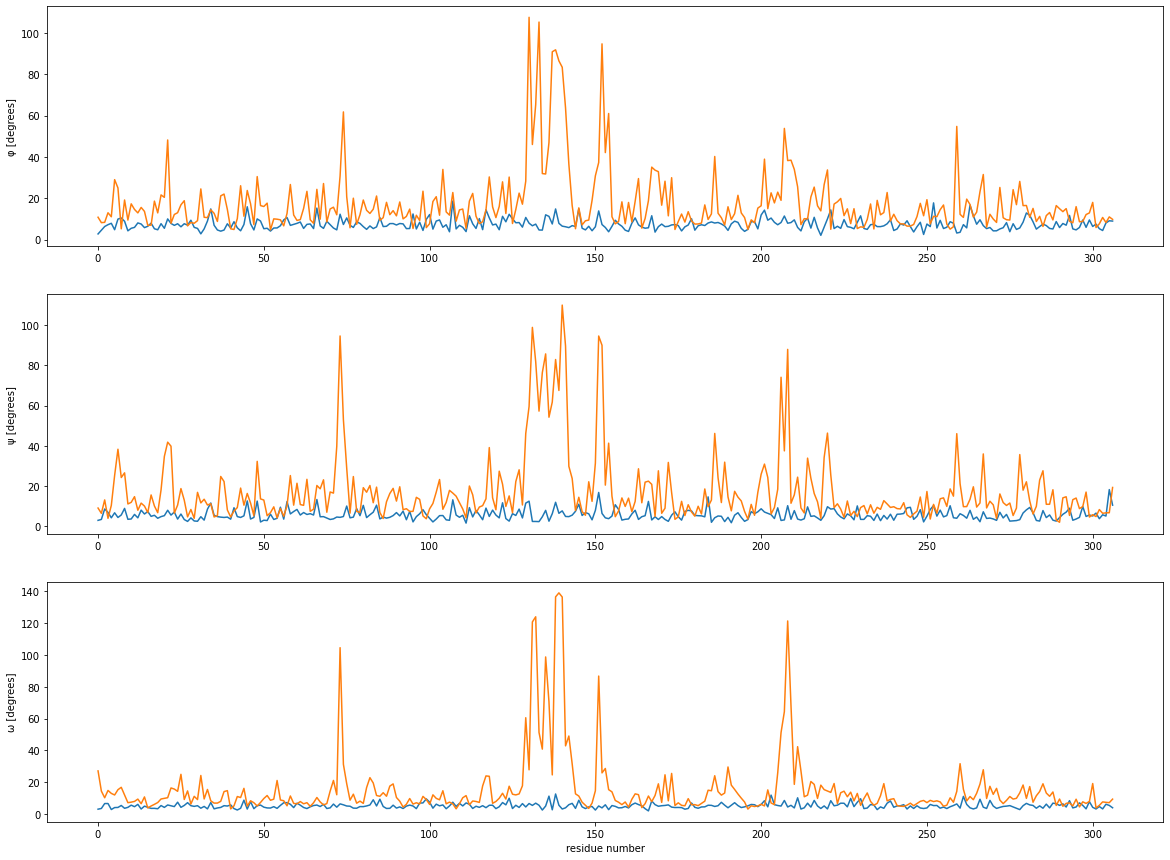

In [106]:
fig = plt.figure(figsize=(20,15))

fig.add_subplot(3, 1, 1)
li = dihedral_std(phi_array1.copy())
plt.plot(list(range(len(li))), li)
li = dihedral_std(phi_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.ylabel(u'\u03c6 [degrees]')

fig.add_subplot(3, 1, 2)
# li = psi_array1.mean(axis=axis)
li = dihedral_std(psi_array1.copy())
plt.plot(list(range(len(li))), li)
# li = psi_array2.mean(axis=axis)
li = dihedral_std(psi_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.ylabel(u'\u03c8 [degrees]')

fig.add_subplot(3, 1, 3)
li = dihedral_std(omega_array1.copy())
plt.plot(list(range(len(li))), li)
li = dihedral_std(omega_array2.copy())
print(np.argsort(li)[::-1][:50])
plt.plot(list(range(len(li))), li)
plt.xlabel("residue number")
plt.ylabel(u'\u03c9 [degrees]')